# Thesis Project

## Explanatory Data Analysis (EDA)

In [1]:
import os
import pandas as pd

csv_directory = r'C:\Users\nicka\Downloads\mimic-iv-2.2\datasets'
csv_file_path = os.path.join(csv_directory, 'icu_data_final_dataset.csv')
icu_data = pd.read_csv(csv_file_path)

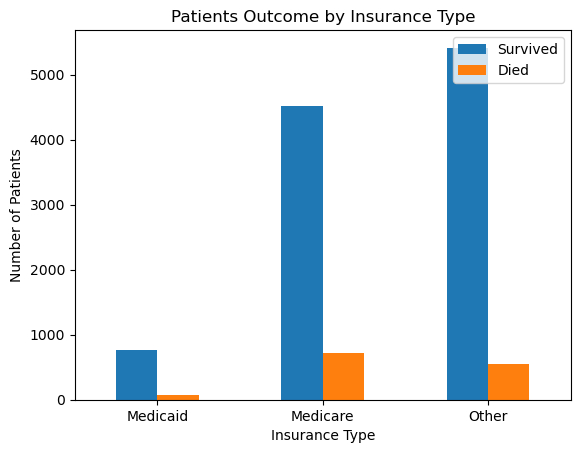

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

insurance_counts = icu_data.groupby(['insurance', 'deathtime']).size().unstack(fill_value=0)

# Plotting the bar plot
ax = insurance_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Patients Outcome by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
ax.legend(['Survived', 'Died'], loc='upper right')
plt.show()

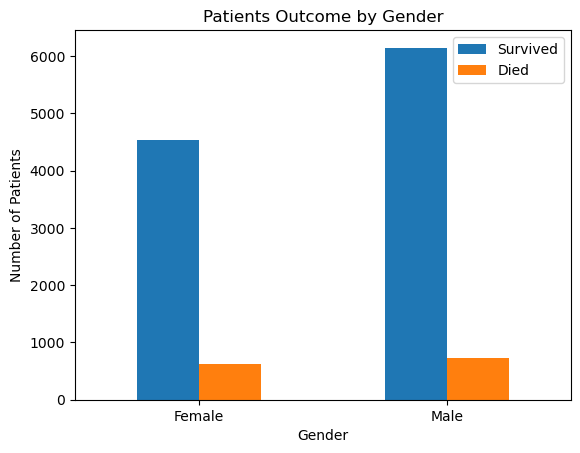

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

gender_counts = icu_data.groupby(['gender', 'deathtime']).size().unstack(fill_value=0)

# Plotting the bar plot
ax = gender_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Patients Outcome by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
ax.legend(['Survived', 'Died'], loc='upper right')
plt.show()

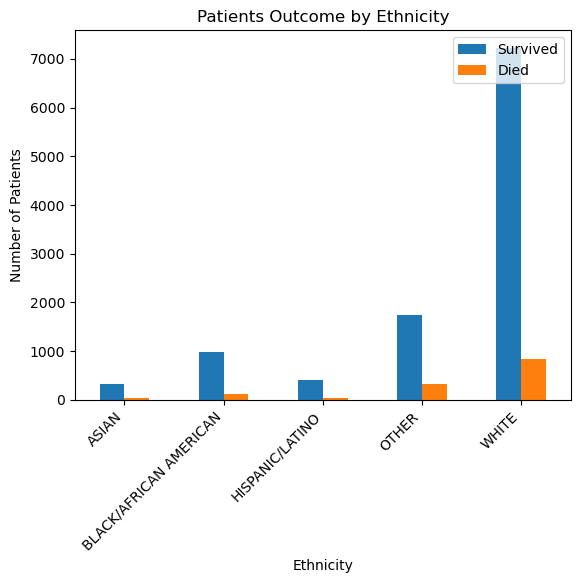

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

race_counts = icu_data.groupby(['race', 'deathtime']).size().unstack(fill_value=0)

# Plotting the bar plot
ax = race_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Patients Outcome by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
ax.legend(['Survived', 'Died'], loc='upper right')
plt.show()

## Identifying the most important Features

In [5]:
selected_predictors = ['gender', 'race', 'age','insurance','deathtime','los','admission location','Arterial Blood Pressure diastolic',
                       'Arterial Blood Pressure mean','Arterial Blood Pressure systolic','Heart Rate','Calcium, Total','Cholesterol Ratio (Total/HDL)',
                       'Oxygen Saturation','Temperature','first_careunit','last_careunit','ART BP Diastolic','ART BP Mean','ART BP Systolic',
                       'Bladder Pressure','Blood Temperature CCO (C)','EtCO2','PAR-Activity','PAR-Circulation','PAR-Oxygen saturation','PAR-Remain sedated',
                       'PAR-Respiration','24 hr Creatinine','24 hr Protein','25-OH Vitamin D']

p_data = icu_data[selected_predictors].copy()

categorical_columns = ['gender', 'race', 'insurance','admission location','first_careunit','last_careunit']
p_data = pd.get_dummies(p_data, columns=categorical_columns, drop_first=True)
p_data = p_data.astype(int)
protected_var = ['gender', 'race', 'insurance']

## GLM Model for Feature Selection

In [6]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import auc


p_data['intercept'] = 1

X = p_data.loc[:, p_data.columns != 'deathtime']
y = p_data['deathtime']

#GLM model using ALL predictors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


glm_all = sm.GLM(y_train, X_train, family=sm.families.Binomial())
glm_all_result = glm_all.fit()

glm_all_predicted_values = glm_all_result.predict(X_test)
glm_all_predicted_classes = (glm_all_predicted_values > 0.5).astype(int)

# Identifying significant features
significant_predictors = glm_all_result.pvalues[glm_all_result.pvalues < 0.05].index

#GLM model using MOST IMPORTANT predictors
X_train_significant = X_train[significant_predictors]
X_test_significant = X_test[significant_predictors]


glm_significant = sm.GLM(y_train, X_train_significant, family=sm.families.Binomial())
glm_significant_result = glm_significant.fit()

glm_significant_predicted_values = glm_significant_result.predict(X_test_significant)
glm_significant_predicted_classes = (glm_significant_predicted_values > 0.5).astype(int)

In [7]:
print(glm_all_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              deathtime   No. Observations:                 9638
Model:                            GLM   Df Residuals:                     9581
Model Family:                Binomial   Df Model:                           56
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2599.8
Date:                Thu, 20 Jun 2024   Deviance:                       5199.5
Time:                        04:14:21   Pearson chi2:                 8.83e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.1355
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [8]:
print(glm_significant_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              deathtime   No. Observations:                 9638
Model:                            GLM   Df Residuals:                     9623
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2689.2
Date:                Thu, 20 Jun 2024   Deviance:                       5378.5
Time:                        04:14:22   Pearson chi2:                 9.06e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1193
Covariance Type:            nonrobust                                         
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

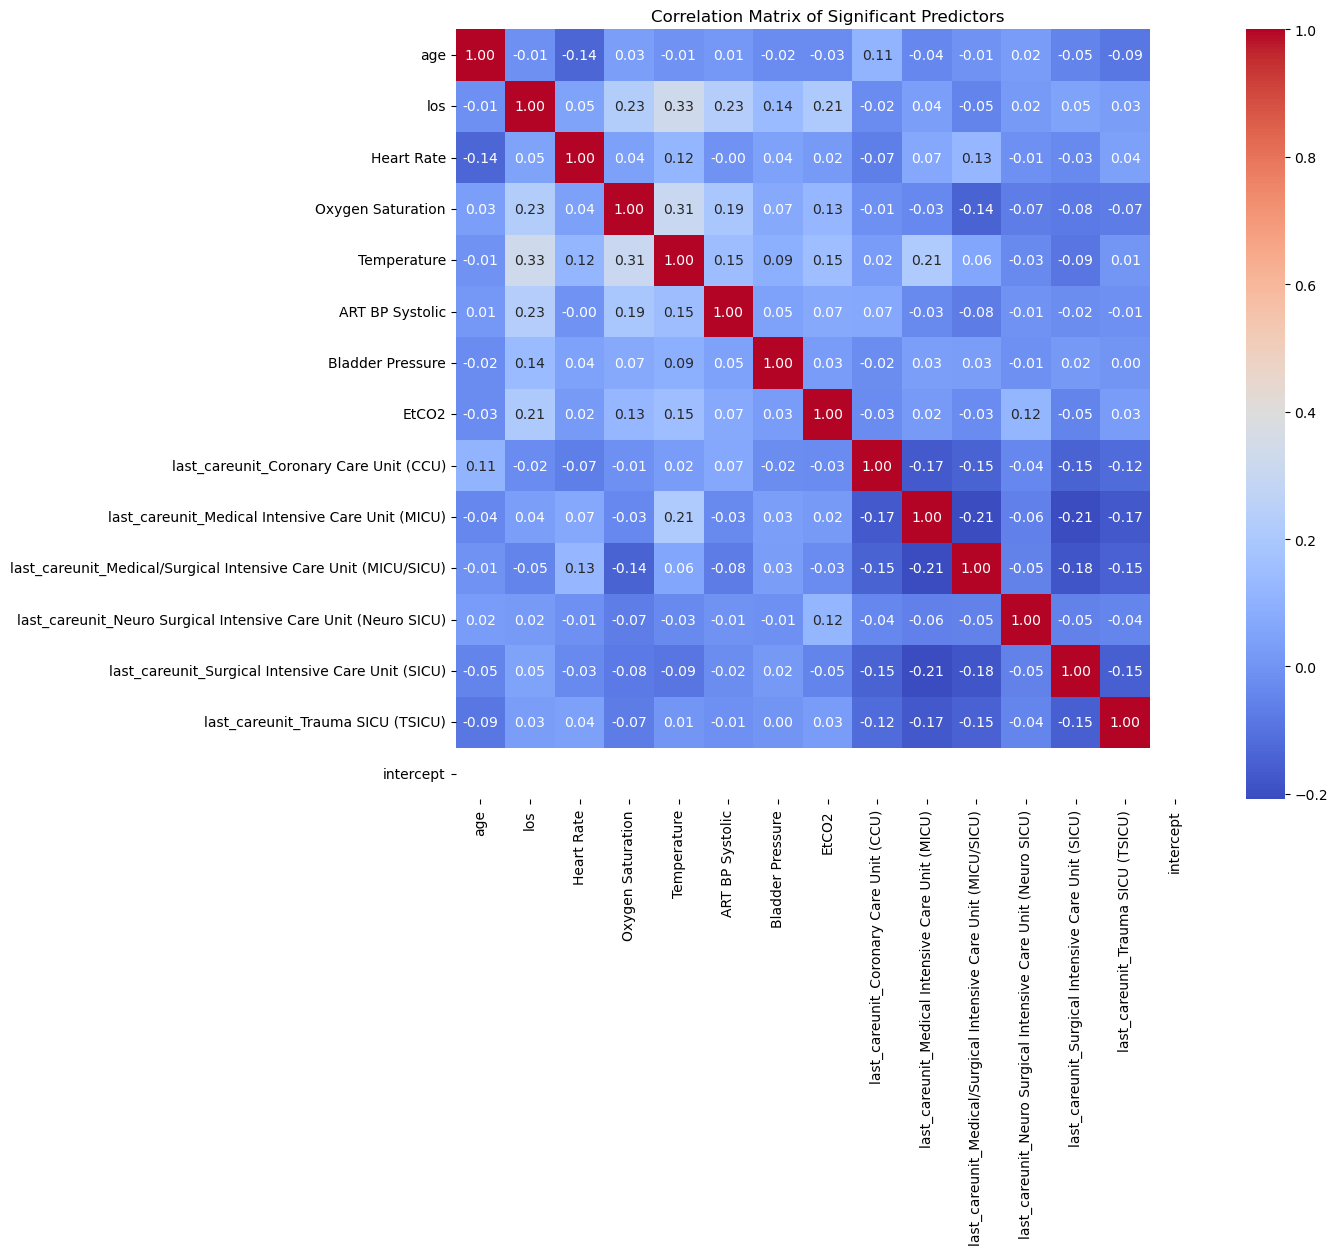

In [9]:
import seaborn as sns

#Correlation Matrix for significant features
X_significant = X_train[significant_predictors]
correlation_matrix = X_significant.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Significant Predictors')
plt.show()

## Baseline Neural Network Model

In [10]:
#Initializing the dataset again
selected_predictors = ['gender', 'race', 'age','insurance','deathtime','los','admission location','Arterial Blood Pressure diastolic',
                       'Arterial Blood Pressure mean','Arterial Blood Pressure systolic','Heart Rate','Calcium, Total','Cholesterol Ratio (Total/HDL)',
                       'Oxygen Saturation','Temperature','first_careunit','last_careunit','ART BP Diastolic','ART BP Mean','ART BP Systolic',
                       'Bladder Pressure','Blood Temperature CCO (C)','EtCO2','PAR-Activity','PAR-Circulation','PAR-Oxygen saturation','PAR-Remain sedated',
                       'PAR-Respiration','24 hr Creatinine','24 hr Protein','25-OH Vitamin D']

p_data = icu_data[selected_predictors].copy()

categorical_columns = ['gender', 'race', 'insurance','admission location','first_careunit','last_careunit']
p_data = pd.get_dummies(p_data, columns=categorical_columns, drop_first=True)
#p_data = p_data.astype(int)
protected_var = ['gender', 'race', 'insurance']

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import statsmodels.api as sm

X = p_data.loc[:, p_data.columns != 'deathtime']
y = p_data['deathtime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

significant_predictors_nn = glm_all_result.pvalues[glm_all_result.pvalues < 0.05].index.to_list()
significant_predictors_nn.pop()

# Neural Network model using ALL predictors
nn_all = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_all.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
nn_all_history = nn_all.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

nn_all_loss, nn_all_accuracy = nn_all.evaluate(X_test, y_test)
print("Test Loss (All Predictors):", nn_all_loss)
print("Test Accuracy (All Predictors):", nn_all_accuracy)

nn_all_y_prob = nn_all.predict(X_test)
nn_all_y_pred = (nn_all_y_prob > 0.5).astype(int)

print("Overall Classification Report for All Predictors:")
print(classification_report(y_test, nn_all_y_pred))

# Neural Network model using ONLY the significant predictors
X_train_significant = X_train[significant_predictors_nn]
X_test_significant = X_test[significant_predictors_nn]

nn_top14 = Sequential([
    Dense(64, input_dim=X_train_significant.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_top14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_top14_history = nn_top14.fit(X_train_significant, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

nn_top14_loss, nn_top14_accuracy = nn_top14.evaluate(X_test_significant, y_test)
print("Test Loss for Significant Predictors:", nn_top14_loss)
print("Test Accuracy for Significant Predictors:", nn_top14_accuracy)

nn_top14_y_prob = nn_top14.predict(X_test_significant)
nn_top14_y_pred = (nn_top14_y_prob > 0.5).astype(int)

print("Overall Classification Report for Significant Predictors:")
print(classification_report(y_test, nn_top14_y_pred))

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7010 - loss: 4.8399 - val_accuracy: 0.8688 - val_loss: 0.4371
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.3994 - val_accuracy: 0.8517 - val_loss: 0.4008
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8932 - loss: 0.3222 - val_accuracy: 0.8786 - val_loss: 0.4549
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8896 - loss: 0.4839 - val_accuracy: 0.8771 - val_loss: 0.3641
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8917 - loss: 0.3392 - val_accuracy: 0.8734 - val_loss: 0.3755
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8890 - loss: 0.2991 - val_accuracy: 0.8781 - val_loss: 0.4169
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8944 - loss: 0.2893 - val_accuracy: 0.8802 - val_loss: 0.3928
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8917 - loss: 0.2944 - val_accuracy: 0.

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7923 - loss: 1.2224 - val_accuracy: 0.8667 - val_loss: 0.3754
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.3450 - val_accuracy: 0.8843 - val_loss: 0.3839
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8906 - loss: 0.3183 - val_accuracy: 0.8740 - val_loss: 0.3500
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - loss: 0.3358 - val_accuracy: 0.8320 - val_loss: 0.3925
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.3468 - val_accuracy: 0.8797 - val_loss: 0.3493
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8691 - loss: 0.3714
Test Loss for Significant Predictors: 0.3789036273956299
Test Accuracy for Significant Predictors: 0.8601659536361694
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Overall Classification Report for Significant Predictors:
              precision    recall  f1-score   support

           0       0.89     

In [12]:
from sklearn.metrics import classification_report

def generate_classification_reports(icu_data, X_test, y_test, y_pred_all, y_pred_significant, protected_vars):
    for var in protected_vars:
        unique_values = icu_data[var].unique()
        for value in unique_values:
            mask = (icu_data.loc[X_test.index, var] == value)
            
            y_test_subset_all = y_test[mask]
            y_pred_subset_all = y_pred_all[mask]
            y_pred_subset_significant = y_pred_significant[mask]
            
            print(f"\nClassification Report for {var} = {value} (All Predictors):")
            print(classification_report(y_test_subset_all, y_pred_subset_all))
            
            print(f"\nClassification Report for {var} = {value} (Significant Predictors):")
            print(classification_report(y_test_subset_all, y_pred_subset_significant))

In [13]:
protected_vars = ['gender', 'race', 'insurance']
generate_classification_reports(icu_data, X_test, y_test, nn_all_y_pred, nn_top14_y_pred, protected_vars)


Classification Report for gender = Female (All Predictors):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       878
           1       0.45      0.21      0.29       135

    accuracy                           0.86      1013
   macro avg       0.67      0.59      0.61      1013
weighted avg       0.83      0.86      0.84      1013


Classification Report for gender = Female (Significant Predictors):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       878
           1       0.41      0.19      0.26       135

    accuracy                           0.86      1013
   macro avg       0.65      0.58      0.59      1013
weighted avg       0.82      0.86      0.83      1013


Classification Report for gender = Male (All Predictors):
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1217
           1       0.45      0.22      0.30     

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curves(models, y_test, y_prob, labels, title='ROC Curve Comparison'):
    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        roc_auc = roc_auc_score(y_test, y_prob[i])
        fpr, tpr, _ = roc_curve(y_test, y_prob[i])
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

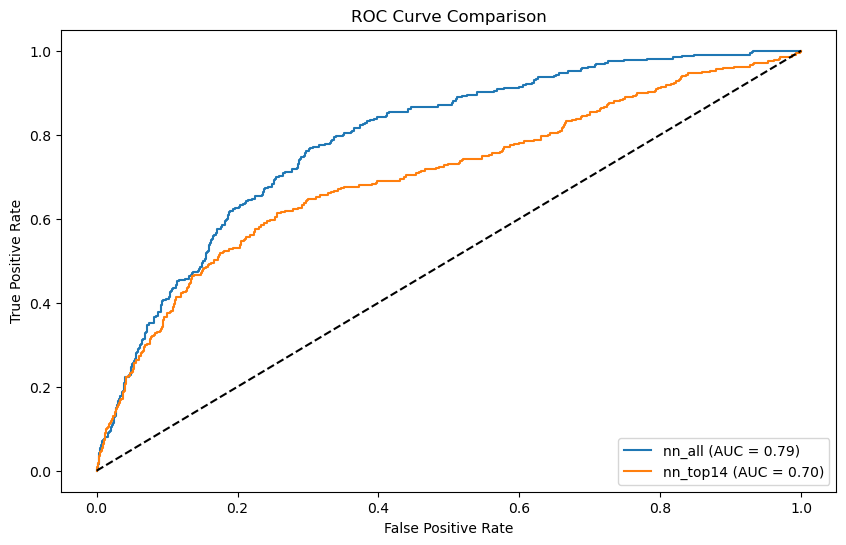

In [15]:
models = ['nn_all', 'nn_top14']
predicted_values = [nn_all_y_prob, nn_top14_y_prob]
labels = ['nn_all', 'nn_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

In [16]:
import numpy as np

def plot_roc_curve(ax, y_true, y_prob, subgroup, group_name):
   
    for group in np.unique(subgroup):
        idx = subgroup == group
        y_true_group = y_true[idx]
        y_prob_group = y_prob[idx]
        
        fpr, tpr, _ = roc_curve(y_true_group, y_prob_group)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, label=f'{group_name} = {group} (AUC = {roc_auc:.2f})')
    
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve by {group_name}')
    ax.legend(loc='lower right')

def plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, y_prob_all, y_prob_significant, protected_variables):
   
    for var in protected_variables:
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        
        plot_roc_curve(axs[0], y_test, y_prob_all, icu_data.loc[X_test.index, var], f'{var} (All Predictors)')
        plot_roc_curve(axs[1], y_test, y_prob_significant, icu_data.loc[X_test.index, var], f'{var} (Significant Predictors)')
        
        plt.tight_layout()
        plt.show()

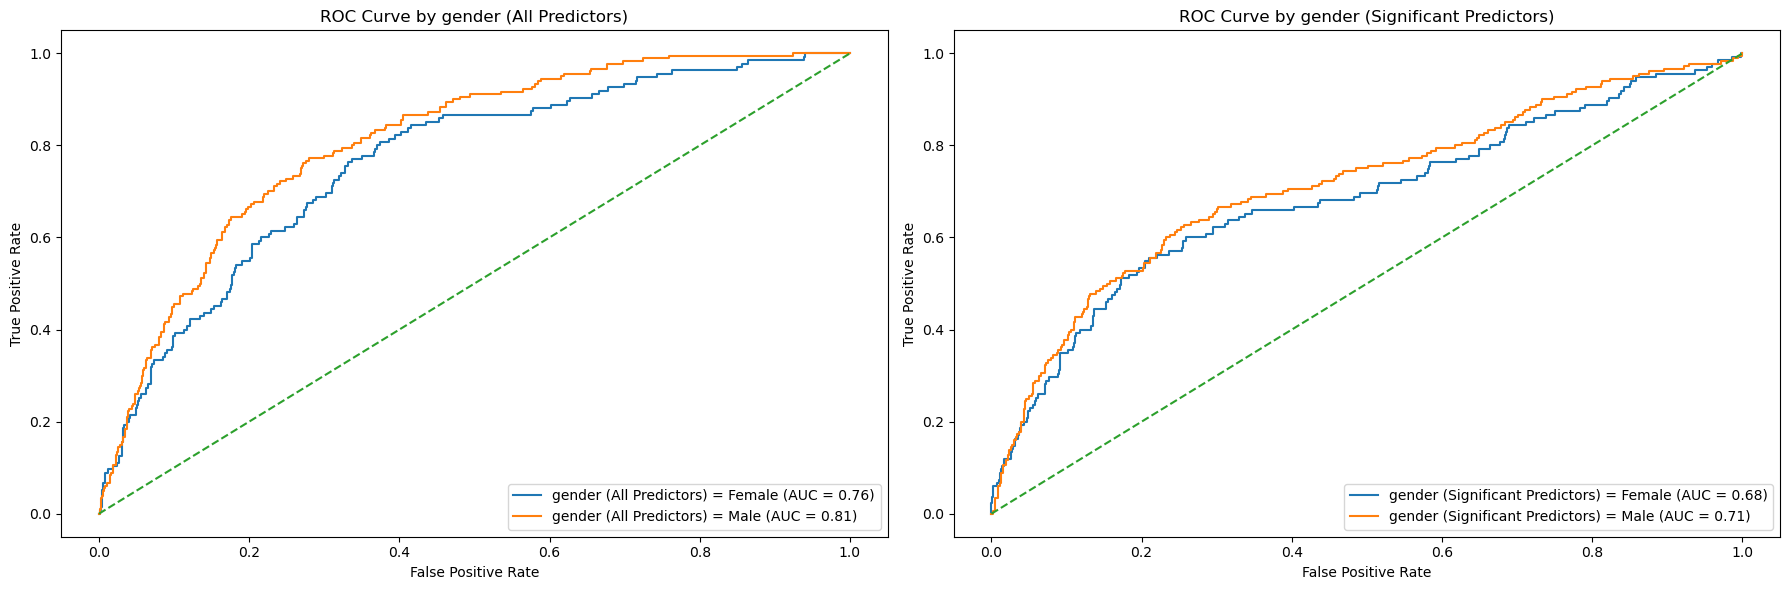

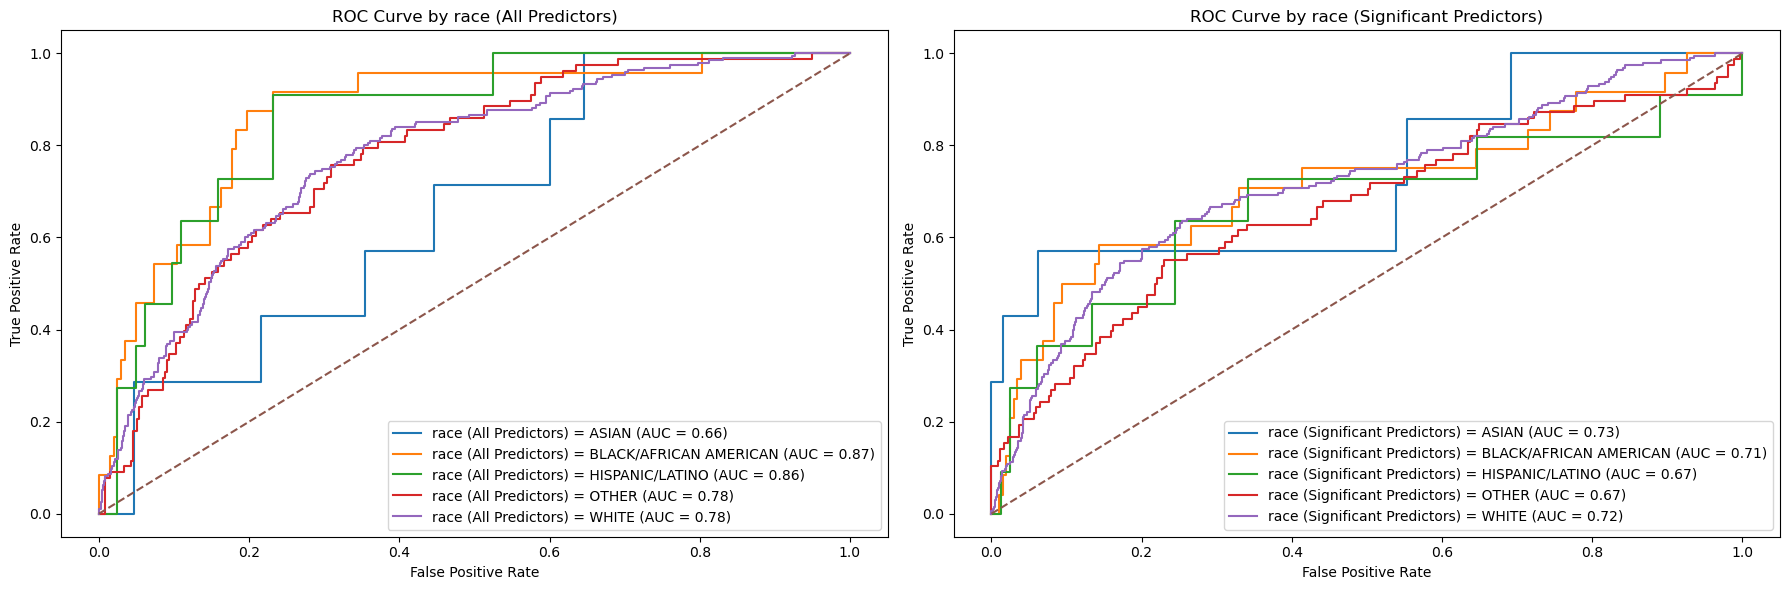

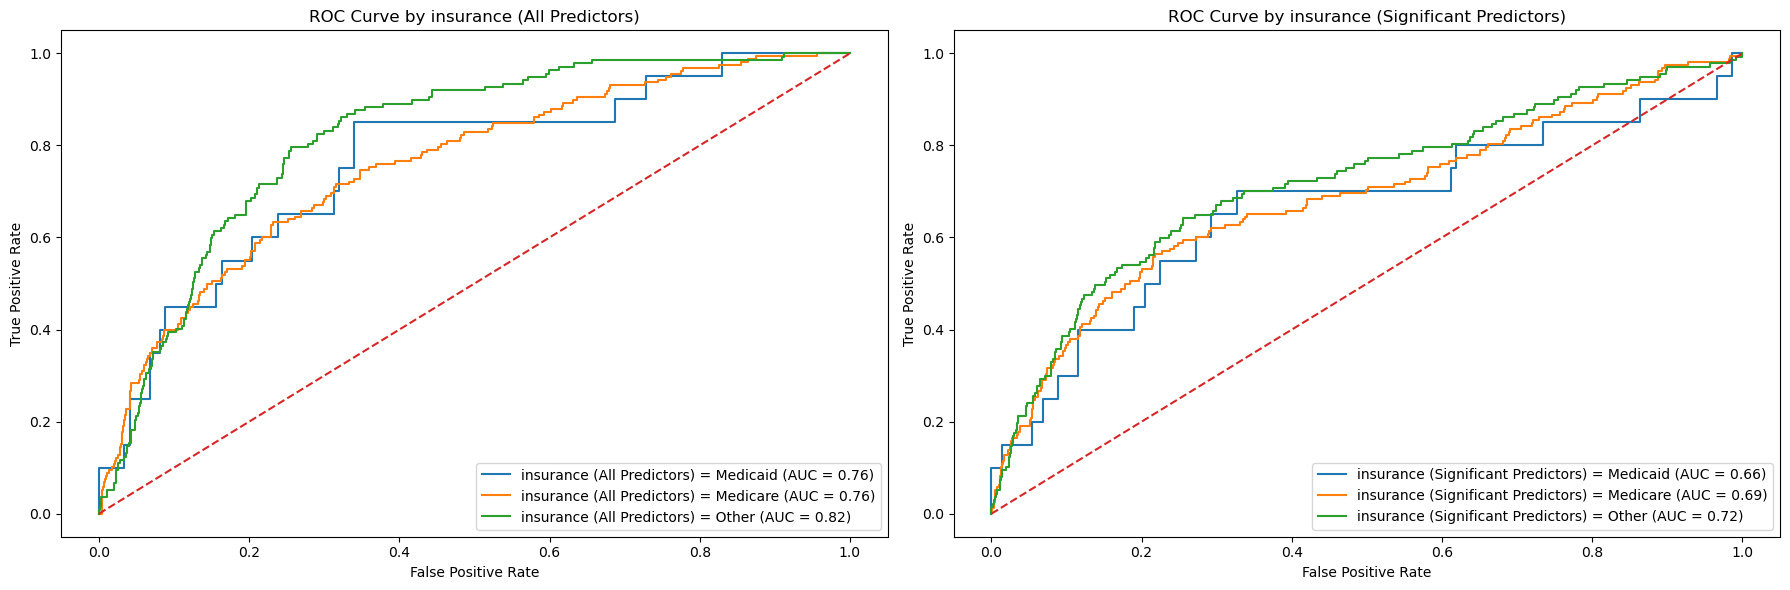

In [17]:
protected_variables = ['gender', 'race', 'insurance']
plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, nn_all_y_prob, nn_top14_y_prob, protected_variables)

In [18]:
from sklearn.calibration import calibration_curve
from fairlearn.metrics import equalized_odds_difference


def plot_calibration_curve(ax, y_true, y_prob, subgroup, group_name):
 
    for group in np.unique(subgroup):
        idx = subgroup == group
        y_true_group = y_true[idx]
        y_prob_group = y_prob[idx]
        
        prob_true, prob_pred = calibration_curve(y_true_group, y_prob_group, n_bins=10)
        ax.plot(prob_pred, prob_true, marker='o', label=f'{group_name} = {group}')
    
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.set_title(f'Calibration Curve by {group_name}')
    ax.legend()

def plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, y_prob_all, y_prob_significant, protected_variables):
 
    for var in protected_variables:
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        
        plot_calibration_curve(axs[0], y_test, y_prob_all, icu_data.loc[X_test.index, var], f'{var} (All Predictors)')
        plot_calibration_curve(axs[1], y_test, y_prob_significant, icu_data.loc[X_test.index, var], f'{var} (Significant Predictors)')
        
        plt.tight_layout()
        plt.show()

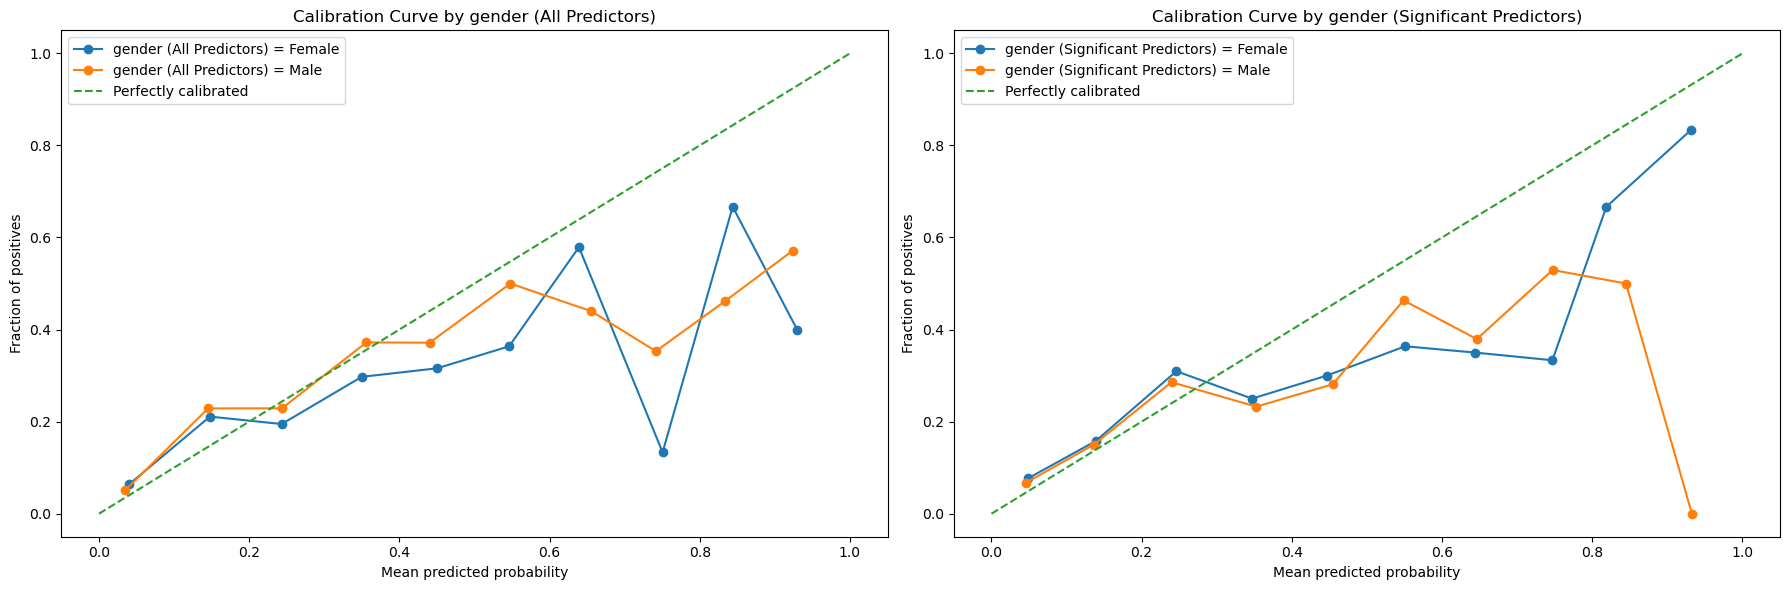

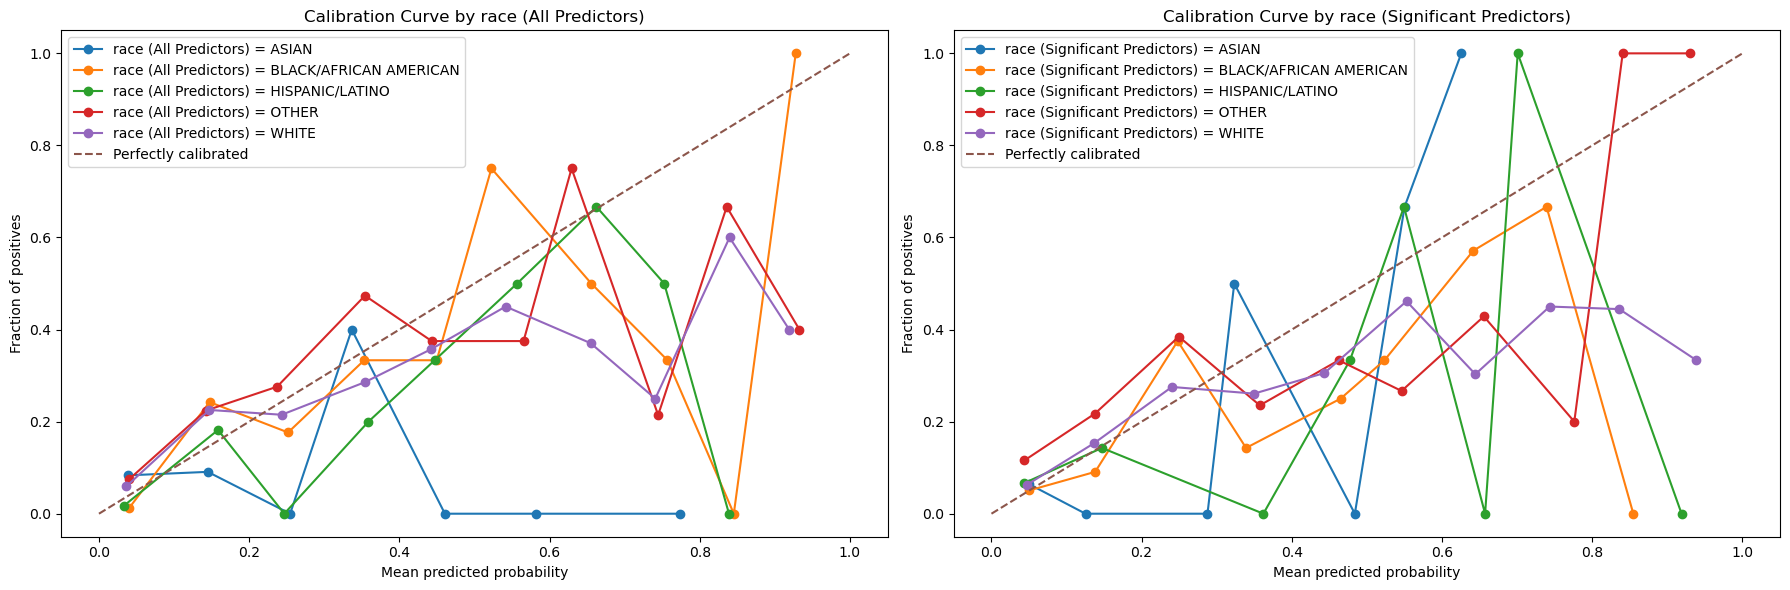

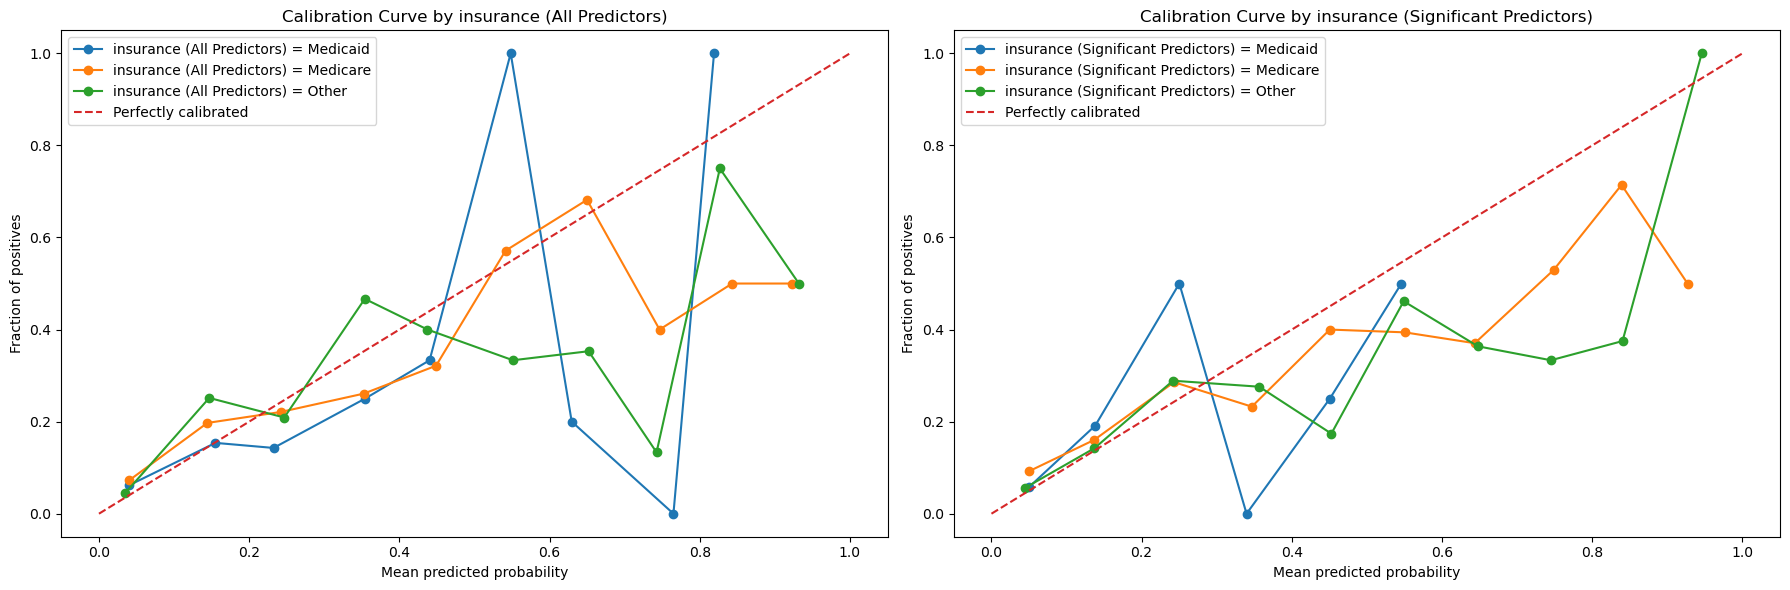

In [19]:
protected_variables = ['gender', 'race', 'insurance']
plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, nn_all_y_prob, nn_top14_y_prob, protected_variables)

In [20]:
def calculate_equalized_odds_difference(y_test, y_pred_all, y_pred_significant, icu_data, X_test, protected_variables):
   
    for var in protected_variables:
        eo_diff_all = equalized_odds_difference(y_test, y_pred_all, sensitive_features=icu_data.loc[X_test.index, var])
        eo_diff_significant = equalized_odds_difference(y_test, y_pred_significant, sensitive_features=icu_data.loc[X_test.index, var])
        
        print(f"\nEqualized Odds Difference by {var.capitalize()} for Model with All Predictors:")
        print(eo_diff_all)
        
        print(f"\nEqualized Odds Difference by {var.capitalize()} for Model with Significant Predictors:")
        print(eo_diff_significant)

In [21]:
protected_variables = ['gender', 'race', 'insurance']
calculate_equalized_odds_difference(y_test, nn_all_y_pred, nn_top14_y_pred, icu_data, X_test, protected_variables)


Equalized Odds Difference by Gender for Model with All Predictors:
0.00740740740740739

Equalized Odds Difference by Gender for Model with Significant Predictors:
0.05740740740740741

Equalized Odds Difference by Race for Model with All Predictors:
0.45454545454545453

Equalized Odds Difference by Race for Model with Significant Predictors:
0.22344322344322343

Equalized Odds Difference by Insurance for Model with All Predictors:
0.13249561119837383

Equalized Odds Difference by Insurance for Model with Significant Predictors:
0.15316455696202533


## Baseline Neural Network + SMOTE Oversampling

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Neural Network using ALL predictors
nn_smote_all = Sequential([
    Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_smote_all.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
nn_smote_all_history = nn_smote_all.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

nn_smote_all_loss, nn_smote_all_accuracy = nn_smote_all.evaluate(X_test, y_test)
print("Test Loss (All Predictors):", nn_smote_all_loss)
print("Test Accuracy (All Predictors):", nn_smote_all_accuracy)

nn_smote_all_y_prob = nn_smote_all.predict(X_test).flatten()
nn_smote_all_y_pred = (nn_smote_all_y_prob > 0.5).astype(int)

print("Overall Classification Report for All Predictors:")
print(classification_report(y_test, nn_smote_all_y_pred))

# Neural Network using ONLY significant predictors
X_train_significant = X_train[significant_predictors_nn]
X_test_significant = X_test[significant_predictors_nn]
X_train_significant_resampled, y_train_significant_resampled = smote.fit_resample(X_train_significant, y_train)

nn_smote_top14 = Sequential([
    Dense(64, input_dim=X_train_significant_resampled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_smote_top14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_smote_top14_history = nn_smote_top14.fit(X_train_significant_resampled, y_train_significant_resampled, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

nn_smote_top14_loss, nn_smote_top14_accuracy = nn_smote_top14.evaluate(X_test_significant, y_test)
print("Test Loss for Significant Predictors:", nn_smote_top14_loss)
print("Test Accuracy for Significant Predictors:", nn_smote_top14_accuracy)

nn_smote_top14_y_prob = nn_smote_top14.predict(X_test_significant).flatten()
nn_smote_top14_y_pred = (nn_smote_top14_y_prob > 0.5).astype(int)

print("Overall Classification Report for Significant Predictors:")
print(classification_report(y_test, nn_smote_top14_y_pred))


Epoch 1/20


C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6557 - loss: 2.6498 - val_accuracy: 0.5833 - val_loss: 0.7517
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.5010 - val_accuracy: 0.8177 - val_loss: 0.4255
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8102 - loss: 0.4239 - val_accuracy: 0.8415 - val_loss: 0.3992
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8463 - loss: 0.3709 - val_accuracy: 0.8046 - val_loss: 0.4265
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 0.3351 - val_accuracy: 0.9049 - val_loss: 0.2710
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3151 - val_accuracy: 0.9381 - val_loss: 0.1980
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8828 - loss: 0.3022 - val_accuracy: 0.9261 - val_loss: 0.2001
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8845 - loss: 0.2894 - val_accuracy: 0.9381 - val_

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6358 - loss: 1.3154 - val_accuracy: 0.6897 - val_loss: 0.5681
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7391 - loss: 0.5445 - val_accuracy: 0.6828 - val_loss: 0.5382
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.5066 - val_accuracy: 0.6636 - val_loss: 0.6016
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4547 - val_accuracy: 0.7290 - val_loss: 0.5545
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8128 - loss: 0.4350 - val_accuracy: 0.6528 - val_loss: 0.6802
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.7361 - loss: 0.5871
Test Loss for Significant Predictors: 0.5851699709892273
Test Accuracy for Significant Predictors: 0.7319502234458923
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Overall Classification Report for Significant Predictors:
              precision    recall  f1-score   support

           0       0.93   

In [23]:
generate_classification_reports(icu_data, X_test, y_test, nn_smote_all_y_pred, nn_smote_top14_y_pred, protected_vars)


Classification Report for gender = Female (All Predictors):
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       878
           1       0.25      0.41      0.31       135

    accuracy                           0.75      1013
   macro avg       0.57      0.61      0.58      1013
weighted avg       0.81      0.75      0.78      1013


Classification Report for gender = Female (Significant Predictors):
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       878
           1       0.27      0.63      0.37       135

    accuracy                           0.72      1013
   macro avg       0.60      0.68      0.60      1013
weighted avg       0.84      0.72      0.76      1013


Classification Report for gender = Male (All Predictors):
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1217
           1       0.30      0.51      0.38     

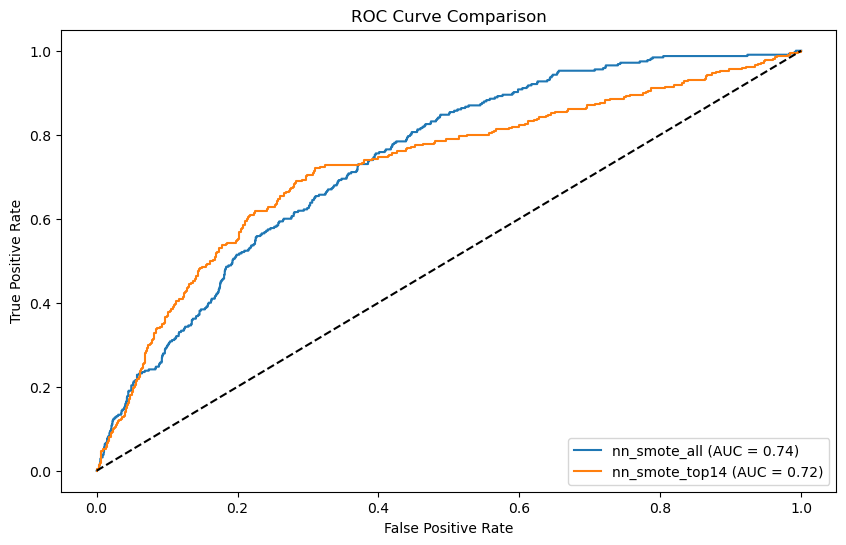

In [24]:
models = ['nn_smote_all', 'nn_smote_top14']
predicted_values = [nn_smote_all_y_prob, nn_smote_top14_y_prob]
labels = ['nn_smote_all', 'nn_smote_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

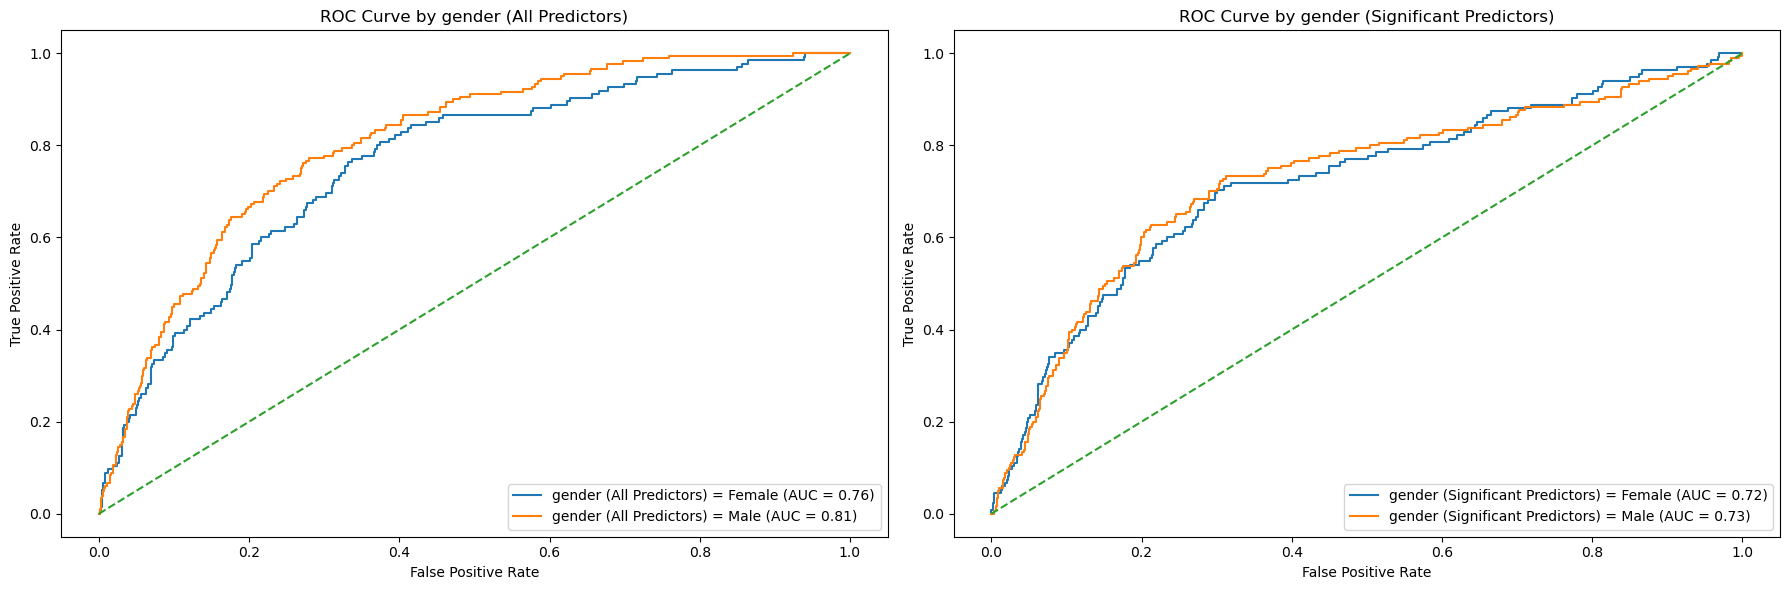

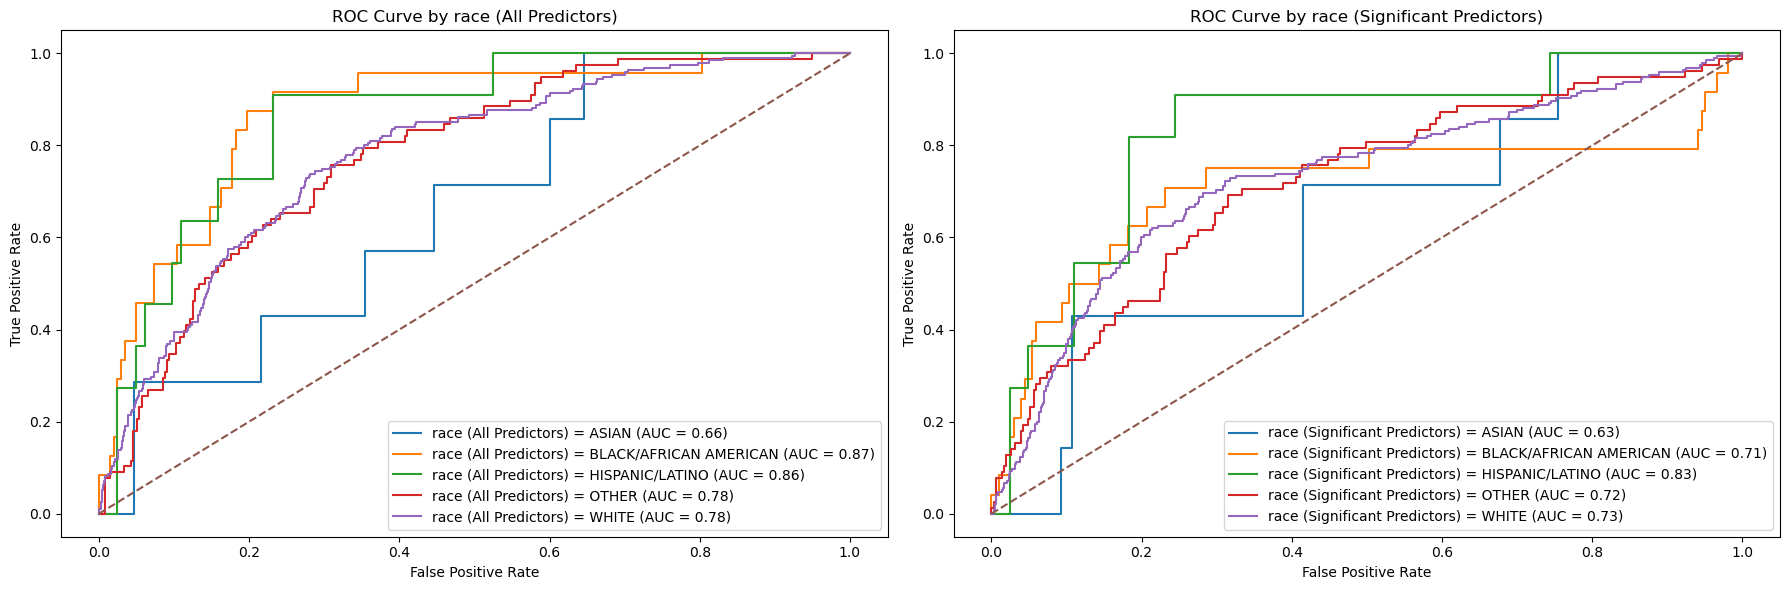

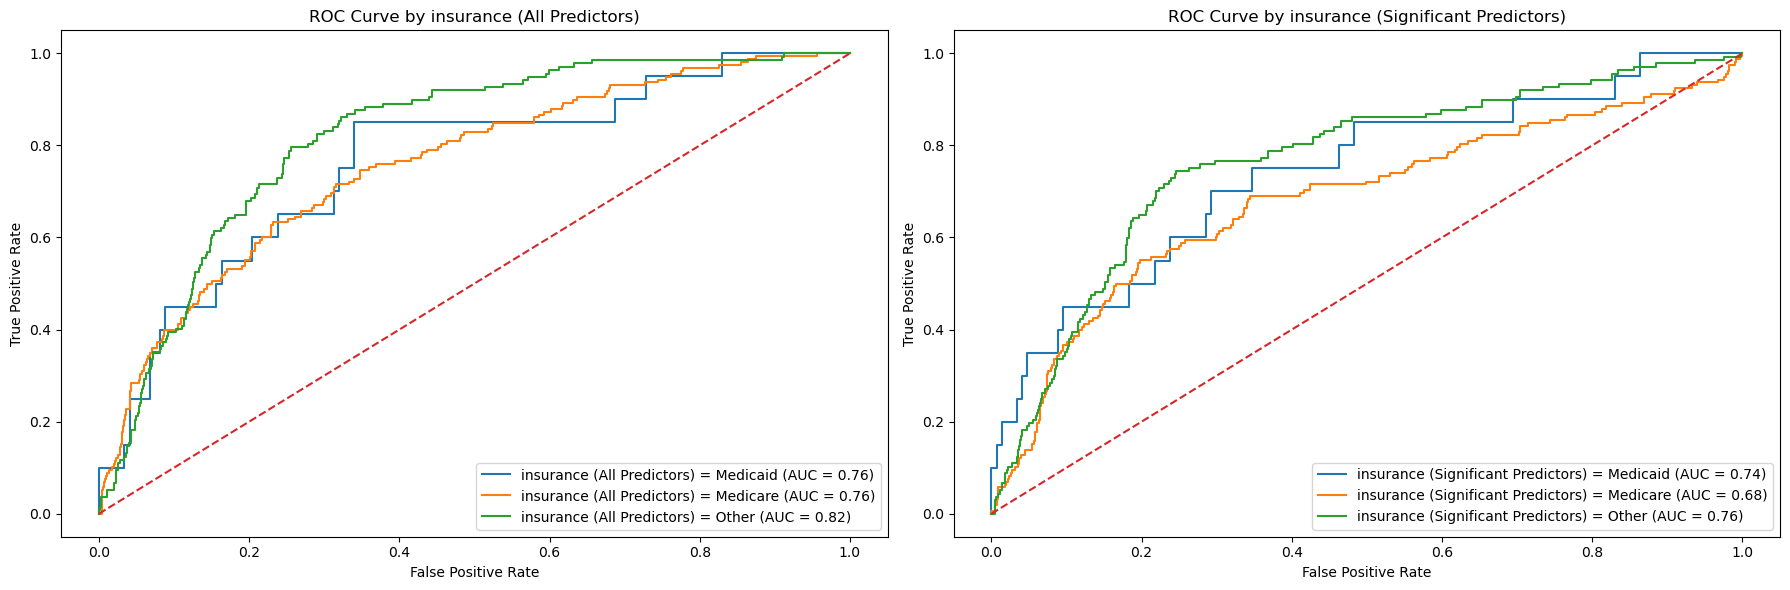

In [25]:
plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, nn_all_y_prob, nn_smote_top14_y_prob, protected_variables)

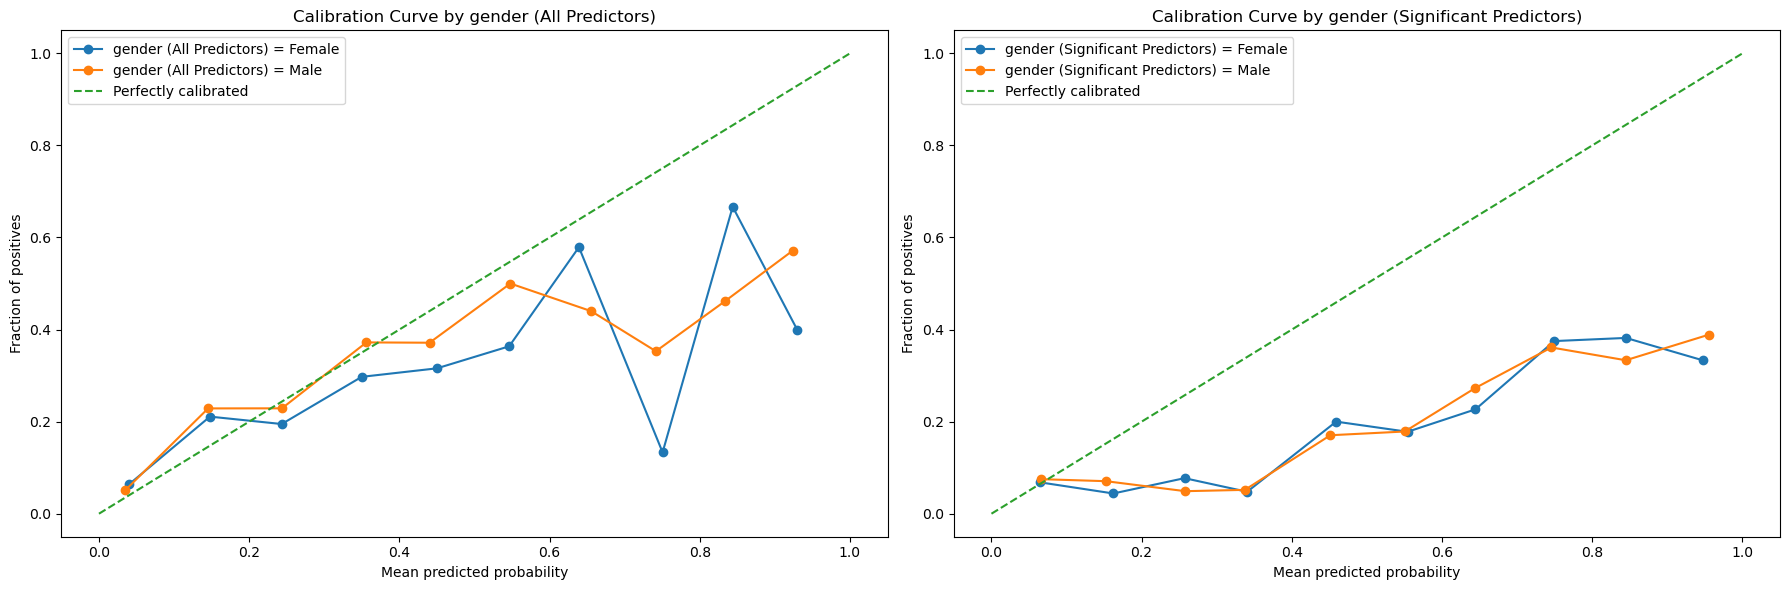

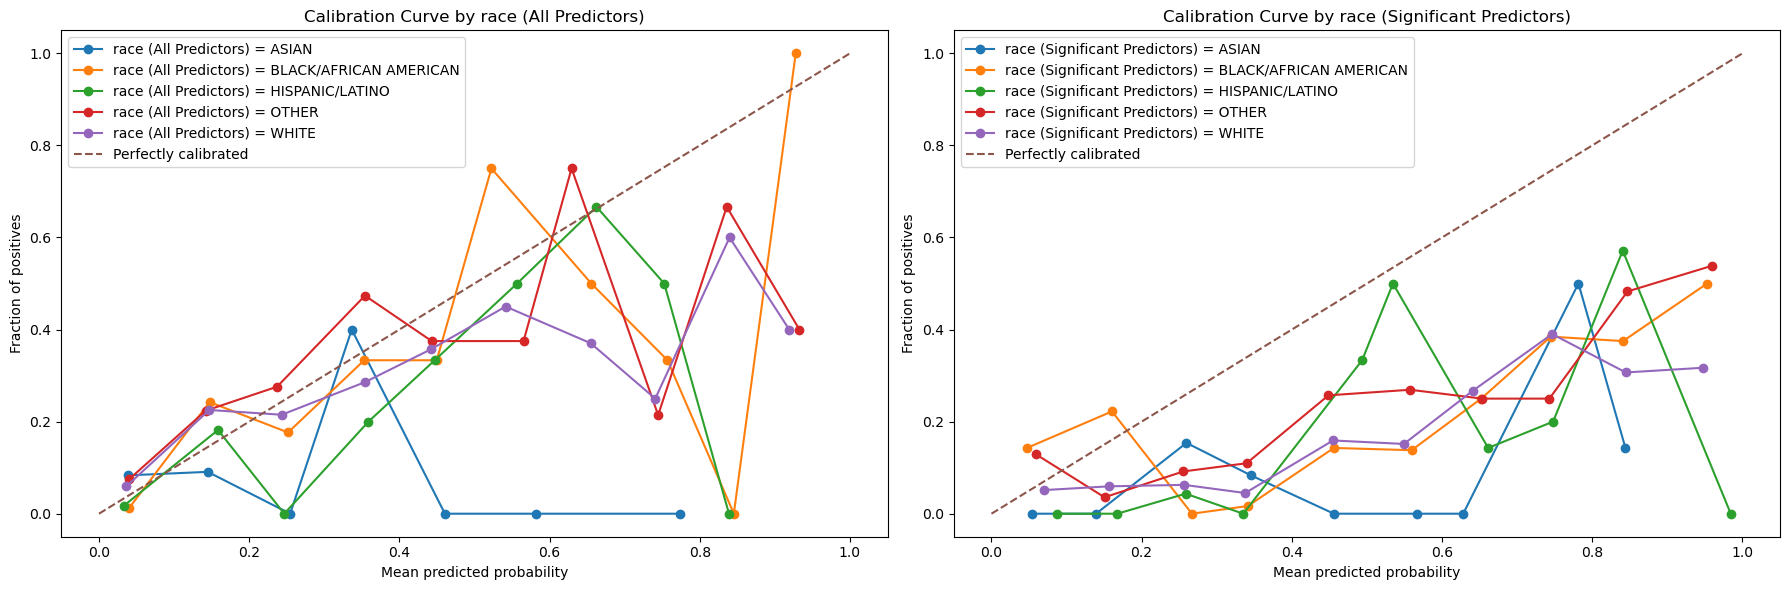

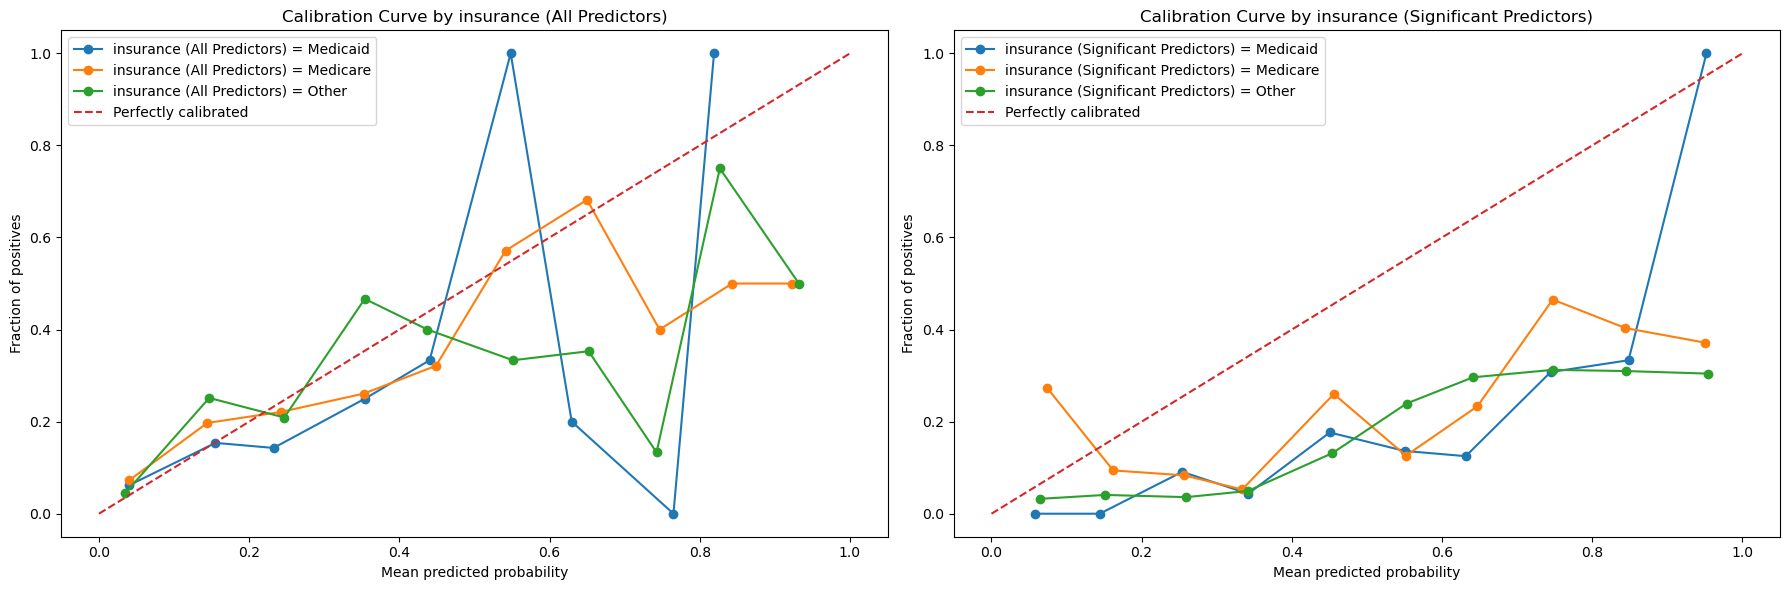

In [26]:
plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, nn_all_y_prob, nn_smote_top14_y_prob, protected_variables)

In [27]:
calculate_equalized_odds_difference(y_test, nn_smote_all_y_pred, nn_smote_top14_y_pred, icu_data, X_test, protected_variables)


Equalized Odds Difference by Gender for Model with All Predictors:
0.09074074074074073

Equalized Odds Difference by Gender for Model with Significant Predictors:
0.025254415896290794

Equalized Odds Difference by Race for Model with All Predictors:
0.3699633699633699

Equalized Odds Difference by Race for Model with Significant Predictors:
0.3896103896103897

Equalized Odds Difference by Insurance for Model with All Predictors:
0.469620253164557

Equalized Odds Difference by Insurance for Model with Significant Predictors:
0.08389540792756167


## Baseline Neural Network + Reweightening

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, Callback

class FairnessCallback(Callback):
    def __init__(self, X_test, y_test, icu_test_data, protected_var):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.icu_test_data = icu_test_data
        self.protected_var = protected_var

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_test).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
        print(f"Epoch {epoch + 1}:")
        for var in self.protected_var:
            sensitive_features = self.icu_test_data[var]
            eo_diff = equalized_odds_difference(self.y_test, y_pred, sensitive_features=sensitive_features)
            print(f"  Equalized Odds Difference for {var}: {eo_diff}")

fairness_callback_all = FairnessCallback(X_test, y_test, icu_data.loc[X_test.index], protected_variables)
fairness_callback_significant = FairnessCallback(X_test_significant, y_test, icu_data.loc[X_test.index], protected_variables)

In [33]:
def calculate_sample_weights(y):
    
    class_weights = dict(zip(*np.unique(y, return_counts=True)))
    total_samples = len(y)
    weights = {k: total_samples/v for k, v in class_weights.items()}
    sample_weights = np.array([weights[label] for label in y])
    return sample_weights

sample_weights_resampled = calculate_sample_weights(y_train_resampled)
sample_weights_significant_resampled = calculate_sample_weights(y_train_significant_resampled)

In [36]:
# Neural Network model using ALL predictors
nn_smote_fair_all = Sequential([
    Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_smote_fair_all.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
nn_smote_fair_all_history = nn_smote_fair_all.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2, sample_weight=sample_weights_resampled, callbacks=[early_stopping, fairness_callback_all])

nn_smote_fair_all_loss, nn_smote_fair_all_accuracy = nn_smote_fair_all.evaluate(X_test, y_test)
print("Test Loss (All Predictors):", nn_smote_fair_all_loss)
print("Test Accuracy (All Predictors):", nn_smote_fair_all_accuracy)

nn_smote_fair_all_y_prob = nn_smote_fair_all.predict(X_test).flatten()
nn_smote_fair_all_y_pred = (nn_smote_fair_all_y_prob > 0.5).astype(int)

print("Overall Classification Report for All Predictors:")
print(classification_report(y_test, nn_smote_fair_all_y_pred))

# Neural Network model using ONLY significant predictors
nn_smote_fair_top14 = Sequential([
    Dense(64, input_dim=X_train_significant_resampled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_smote_fair_top14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_smote_fair_top14_history = nn_smote_fair_top14.fit(X_train_significant_resampled, y_train_significant_resampled, epochs=20, batch_size=64, validation_split=0.2, sample_weight=sample_weights_significant_resampled, callbacks=[early_stopping, fairness_callback_significant])

nn_smote_fair_top14_loss, nn_smote_fair_top14_accuracy = nn_smote_fair_top14.evaluate(X_test_significant, y_test)
print("Test Loss for Significant Predictors:", nn_smote_fair_top14_loss)
print("Test Accuracy for Significant Predictors:", nn_smote_fair_top14_accuracy)

nn_smote_fair_top14_y_prob = nn_smote_fair_top14.predict(X_test_significant).flatten()
nn_smote_fair_top14_y_pred = (nn_smote_fair_top14_y_prob > 0.5).astype(int)

print("Overall Classification Report for Significant Predictors:")
print(classification_report(y_test, nn_smote_fair_top14_y_pred))

Epoch 1/20


C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.6693 - loss: 4
Epoch 1:
  Equalized Odds Difference for gender: 0.07222222222222219
  Equalized Odds Difference for race: 0.4935064935064935
  Equalized Odds Difference for insurance: 0.13406634020142294
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6740 - loss: 4.2776 - val_accuracy: 0.5638 - val_loss: 1.5534
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7826 - loss: 0.967
Epoch 2:
  Equalized Odds Difference for gender: 0.02777777777777779
  Equalized Odds Difference for race: 0.5844155844155845
  Equalized Odds Difference for insurance: 0.08812615955473098
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7842 - loss: 0.9619 - val_accuracy: 0.7950 - val_loss: 0.8735
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.8280 - loss: 0.8
Epoch 3:
  Equalized Odds Difference for gender: 0.07592592592592595
  Equalized Odds Difference for race: 0.6071428571428572
  Equalized Odds Differe

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.6729 - loss: 1.7
Epoch 1:
  Equalized Odds Difference for gender: 0.034397852742937496
  Equalized Odds Difference for race: 0.1785714285714286
  Equalized Odds Difference for insurance: 0.10182481751824812
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6732 - loss: 1.7265 - val_accuracy: 0.7197 - val_loss: 0.9734
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7338 - loss: 1.0
Epoch 2:
  Equalized Odds Difference for gender: 0.061111111111111116
  Equalized Odds Difference for race: 0.13589743589743591
  Equalized Odds Difference for insurance: 0.15417915417915418
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7349 - loss: 1.0937 - val_accuracy: 0.6333 - val_loss: 1.3381
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7523 - loss: 1.0
Epoch 3:
  Equalized Odds Difference for gender: 0.011111111111111127
  Equalized Odds Difference for race: 0.28787878787878785
  Equalized Odds Di

In [38]:
generate_classification_reports(icu_data, X_test, y_test, nn_smote_fair_all_y_pred, nn_smote_fair_top14_y_pred, protected_vars)


Classification Report for gender = Female (All Predictors):
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       878
           1       0.35      0.60      0.44       135

    accuracy                           0.80      1013
   macro avg       0.64      0.71      0.66      1013
weighted avg       0.85      0.80      0.82      1013


Classification Report for gender = Female (Significant Predictors):
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       878
           1       0.26      0.70      0.38       135

    accuracy                           0.69      1013
   macro avg       0.60      0.70      0.59      1013
weighted avg       0.85      0.69      0.74      1013


Classification Report for gender = Male (All Predictors):
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1217
           1       0.33      0.61      0.43     

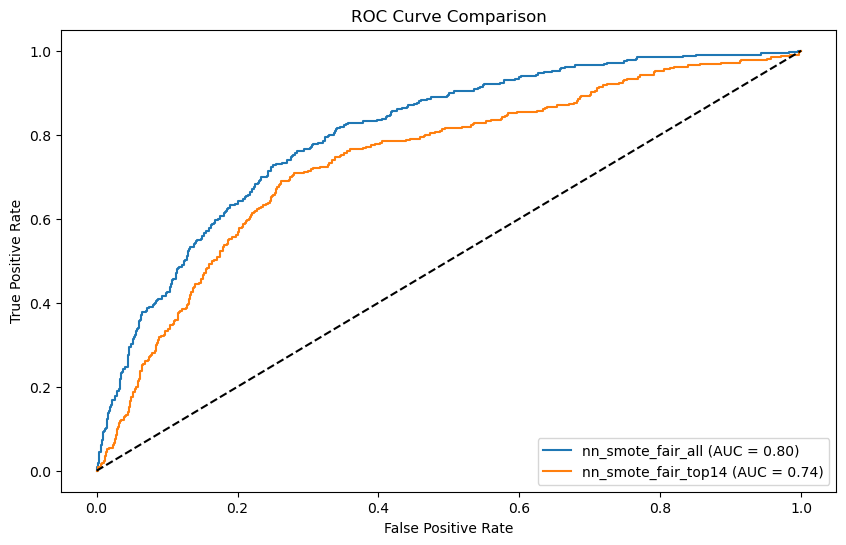

In [39]:
models = ['nn_smote_fair_all', 'nn_smote_fair_top14']
predicted_values = [nn_smote_fair_all_y_prob, nn_smote_fair_top14_y_prob]
labels = ['nn_smote_fair_all', 'nn_smote_fair_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

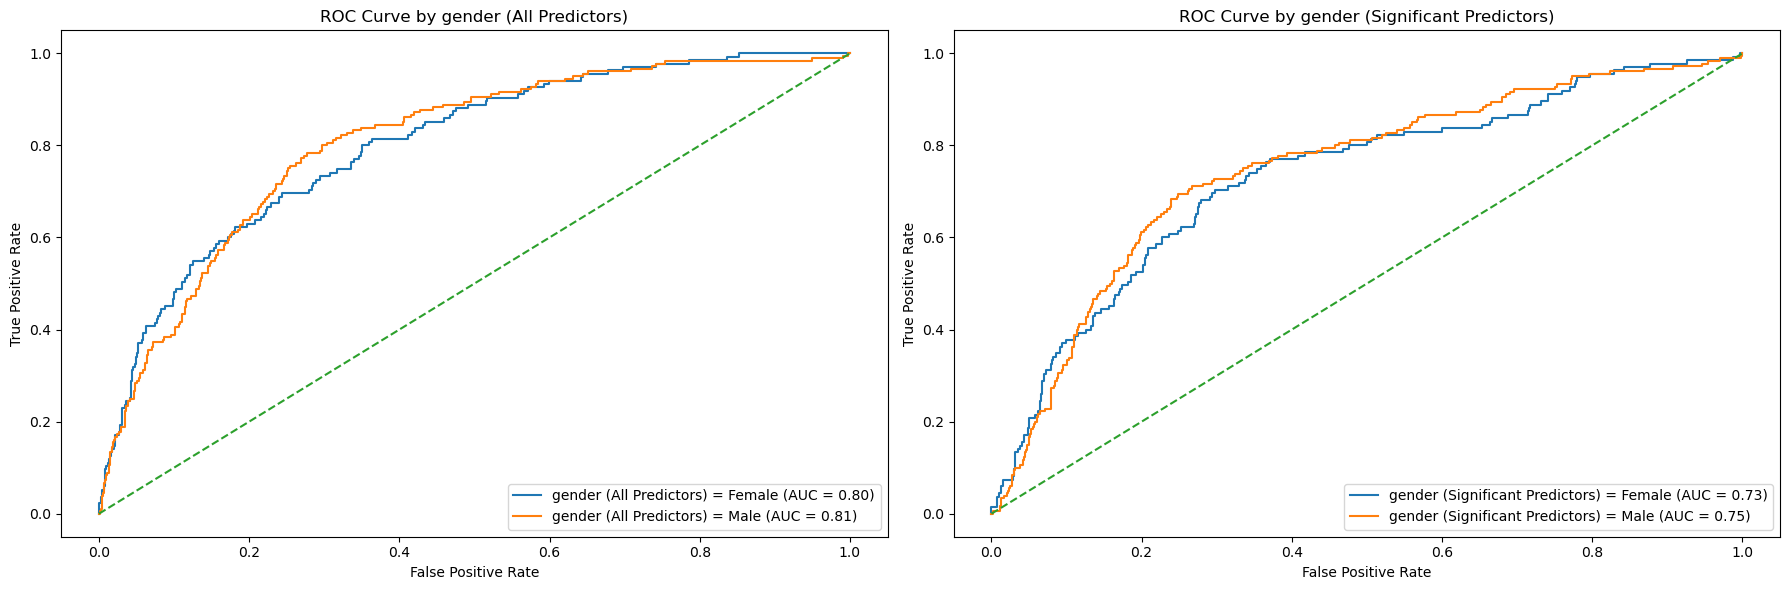

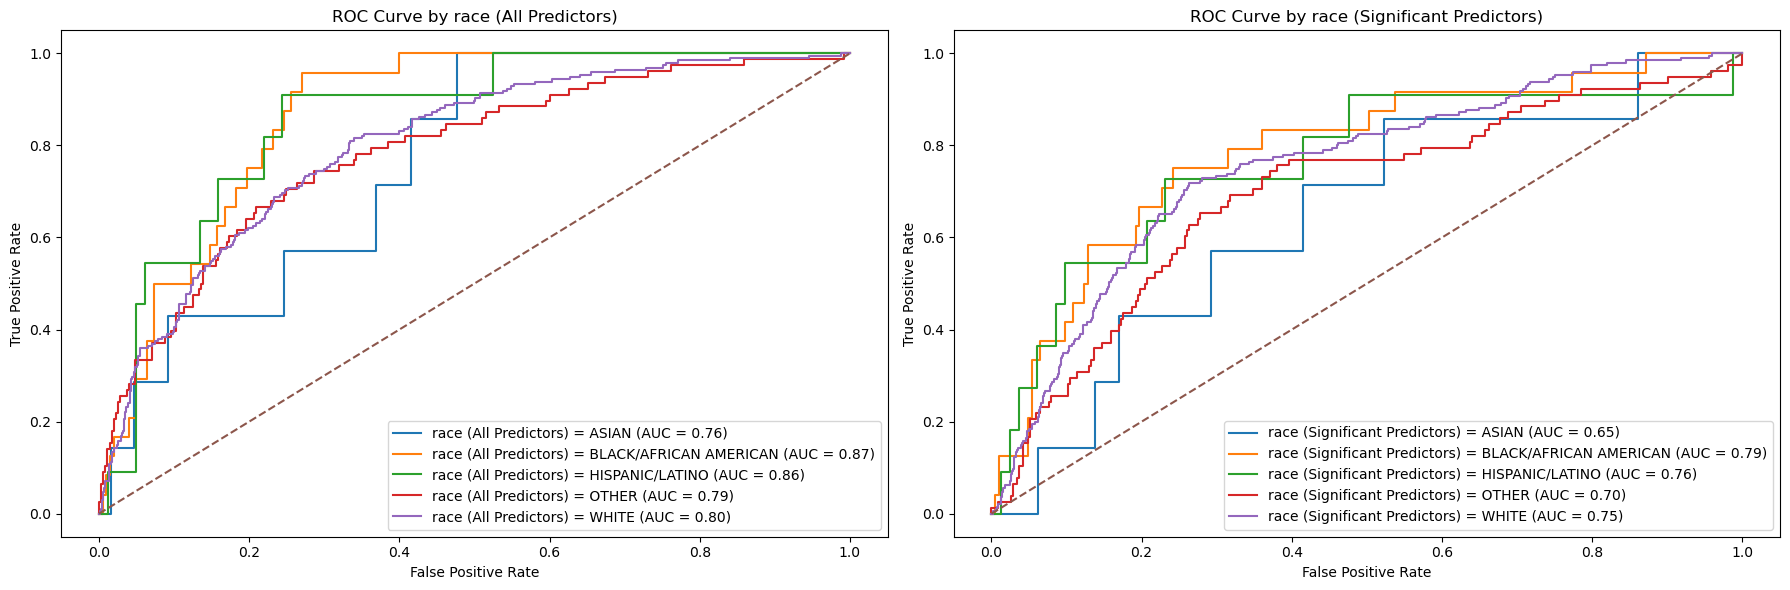

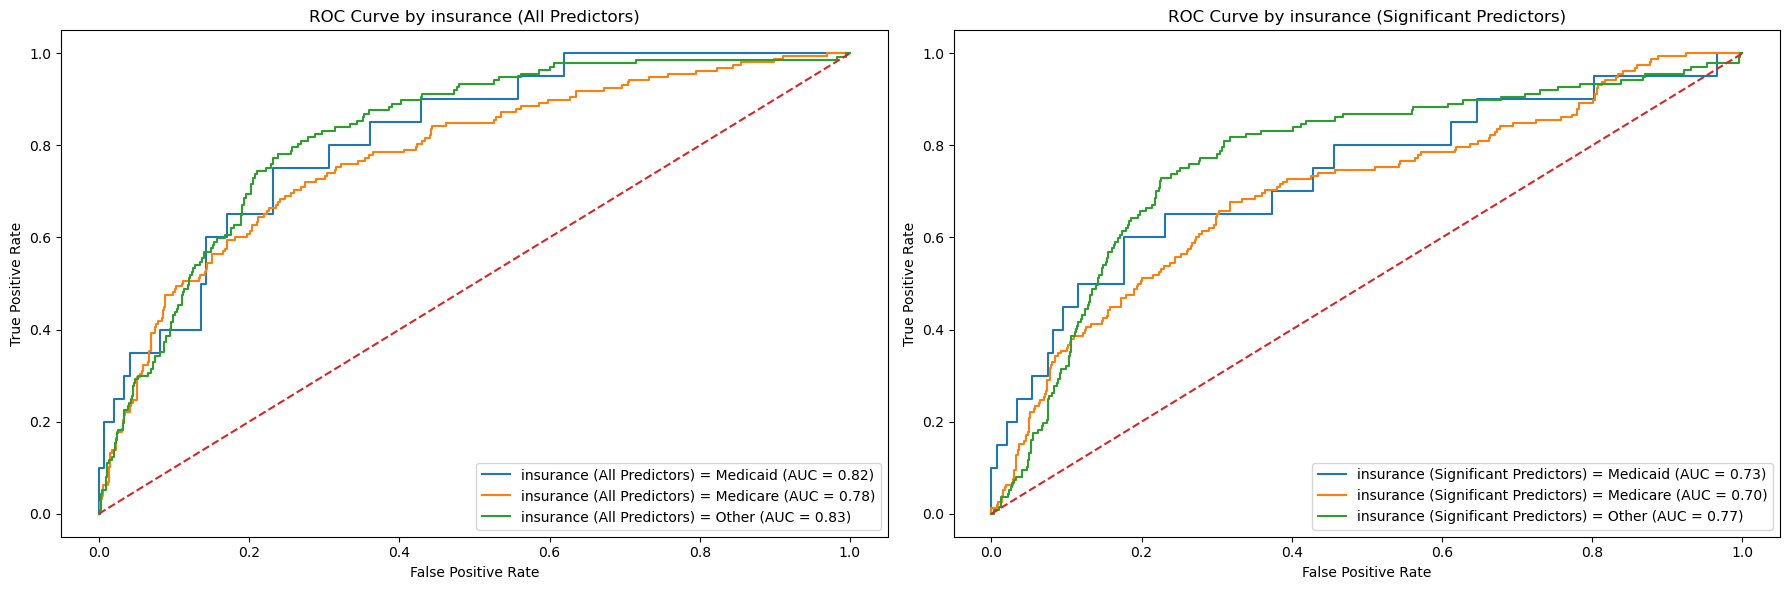

In [40]:
plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, nn_smote_fair_all_y_prob, nn_smote_fair_top14_y_prob, protected_variables)

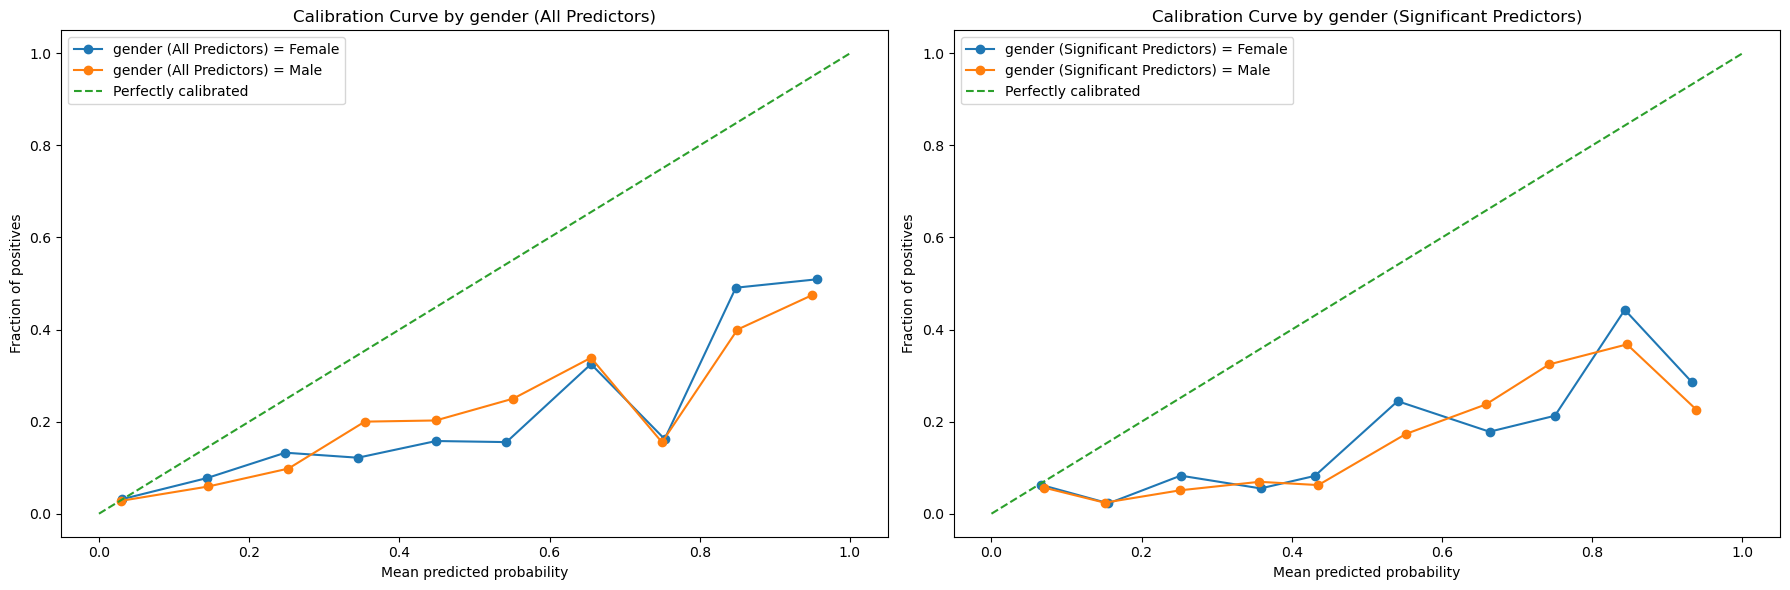

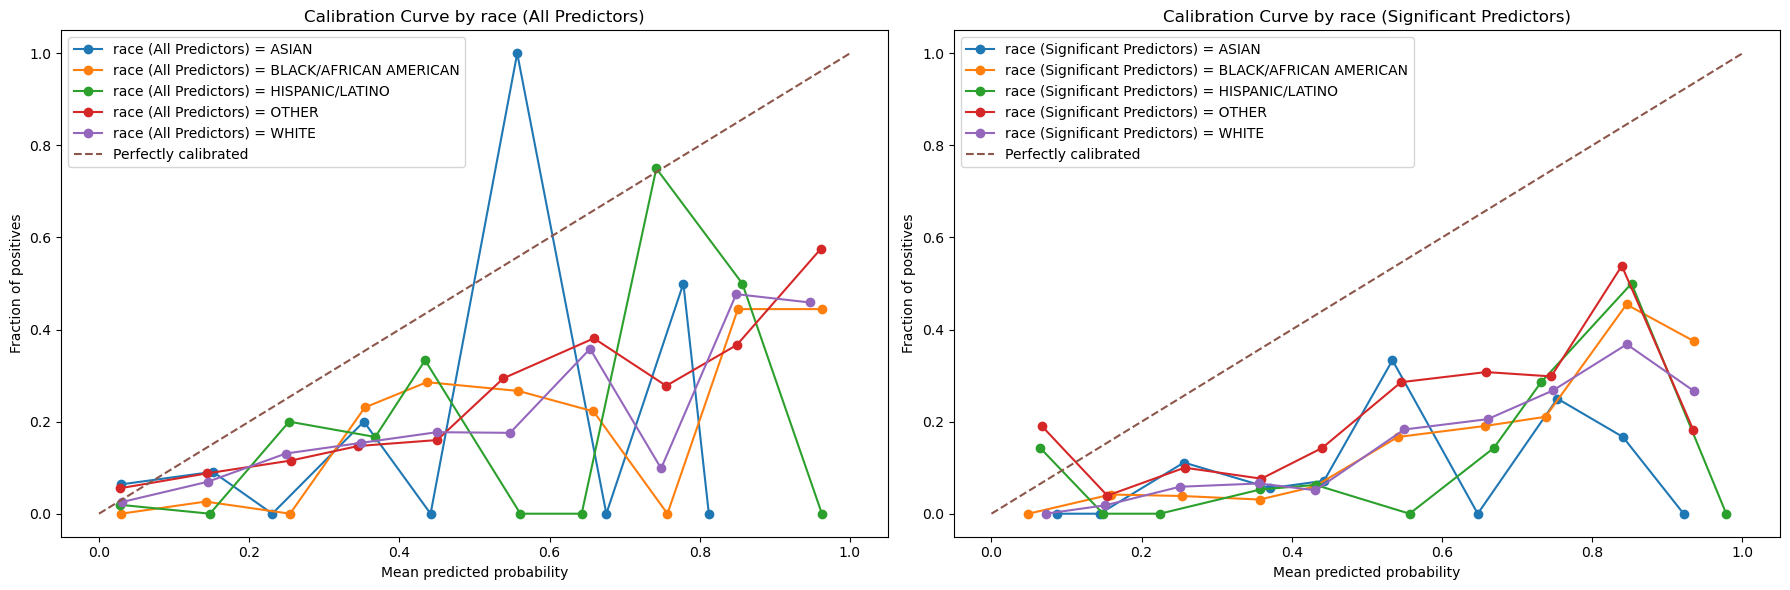

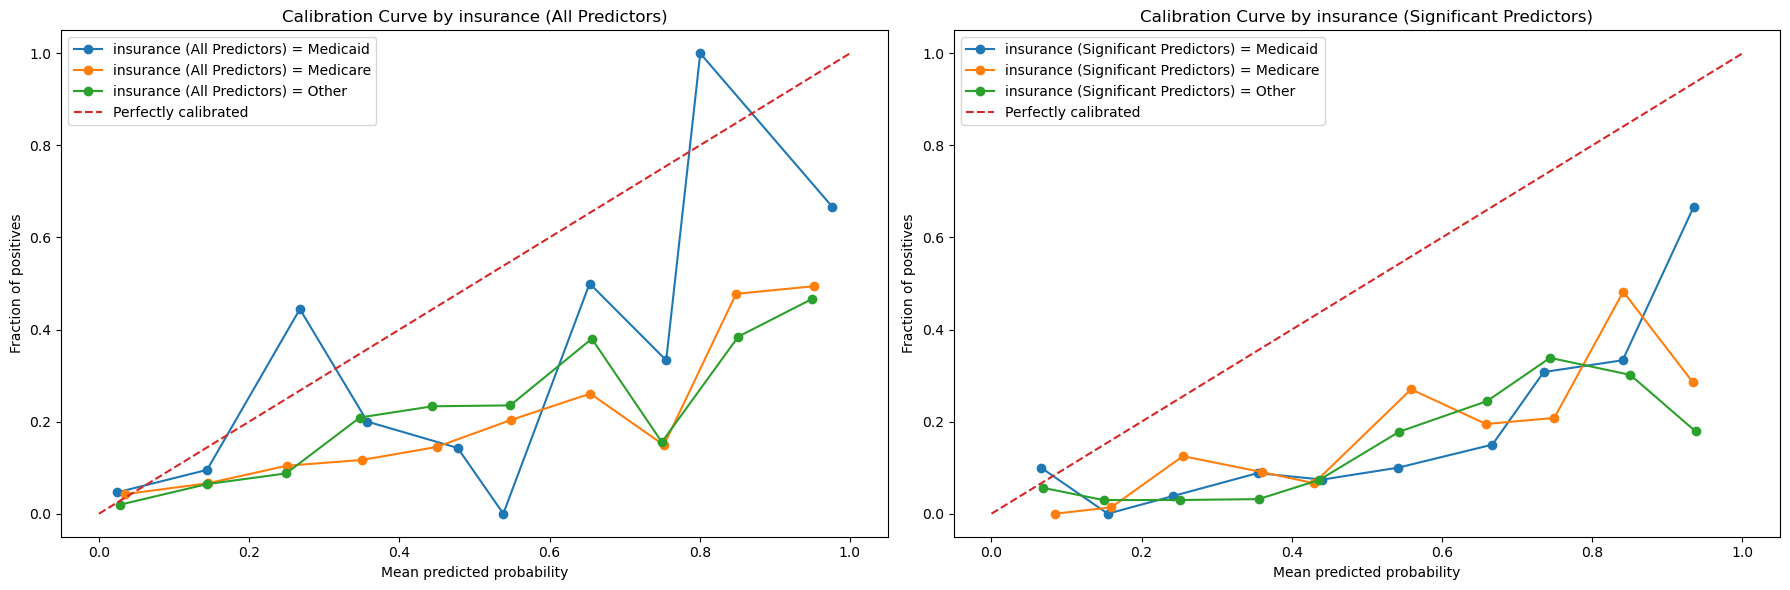

In [41]:
plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, nn_smote_fair_all_y_prob, nn_smote_fair_top14_y_prob, protected_variables)

In [86]:
calculate_equalized_odds_difference(y_test, nn_smote_fair_all_y_pred, nn_smote_fair_top14_y_pred, icu_data, X_test, protected_variables)


Equalized Odds Difference by Gender for Model with All Predictors:
0.011111111111111183

Equalized Odds Difference by Gender for Model with Significant Predictors:
0.034397852742937496

Equalized Odds Difference by Race for Model with All Predictors:
0.4642857142857143

Equalized Odds Difference by Race for Model with Significant Predictors:
0.1785714285714286

Equalized Odds Difference by Insurance for Model with All Predictors:
0.31455696202531647

Equalized Odds Difference by Insurance for Model with Significant Predictors:
0.10182481751824812


## Baseline Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

# Logistic Regrassion using ALL predictors
lr_all = LogisticRegression(max_iter=1000, solver='liblinear')
lr_all.fit(X_train, y_train)

lr_all_y_prob = lr_all.predict_proba(X_test)[:, 1]
lr_all_y_pred = (lr_all_y_prob > 0.5).astype(int)
lr_all_y_prob_accuracy = lr_all.score(X_test, y_test)
print("Test Accuracy (All Predictors):", lr_all_y_prob_accuracy)

print("Overall Classification Report for All Predictors:")
print(classification_report(y_test, lr_all_y_pred))

# Logistic Regrassion using ONLY significant predictors
lr_top14 = LogisticRegression(max_iter=1000, solver='liblinear')
lr_top14.fit(X_train_significant, y_train)

lr_top14_y_prob = lr_top14.predict_proba(X_test_significant)[:, 1]
lr_top14_y_pred = (lr_top14_y_prob > 0.5).astype(int)
lr_top14_accuracy = lr_top14.score(X_test_significant, y_test)
print("Test Accuracy for Significant Predictors:", lr_top14_accuracy)

print("Overall Classification Report for Significant Predictors:")
print(classification_report(y_test, lr_top14_y_pred))

Test Accuracy (All Predictors): 0.8726141078838174
Overall Classification Report for All Predictors:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2095
           1       0.59      0.09      0.15       315

    accuracy                           0.87      2410
   macro avg       0.73      0.54      0.54      2410
weighted avg       0.84      0.87      0.83      2410

Test Accuracy for Significant Predictors: 0.870539419087137
Overall Classification Report for Significant Predictors:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2095
           1       0.58      0.03      0.07       315

    accuracy                           0.87      2410
   macro avg       0.73      0.52      0.50      2410
weighted avg       0.83      0.87      0.82      2410



In [44]:
generate_classification_reports(icu_data, X_test, y_test, lr_all_y_pred, lr_top14_y_pred, protected_vars)


Classification Report for gender = Female (All Predictors):
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       878
           1       0.64      0.12      0.20       135

    accuracy                           0.87      1013
   macro avg       0.76      0.55      0.57      1013
weighted avg       0.85      0.87      0.83      1013


Classification Report for gender = Female (Significant Predictors):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       878
           1       0.57      0.03      0.06       135

    accuracy                           0.87      1013
   macro avg       0.72      0.51      0.49      1013
weighted avg       0.83      0.87      0.81      1013


Classification Report for gender = Male (All Predictors):
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1217
           1       0.52      0.06      0.11     

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

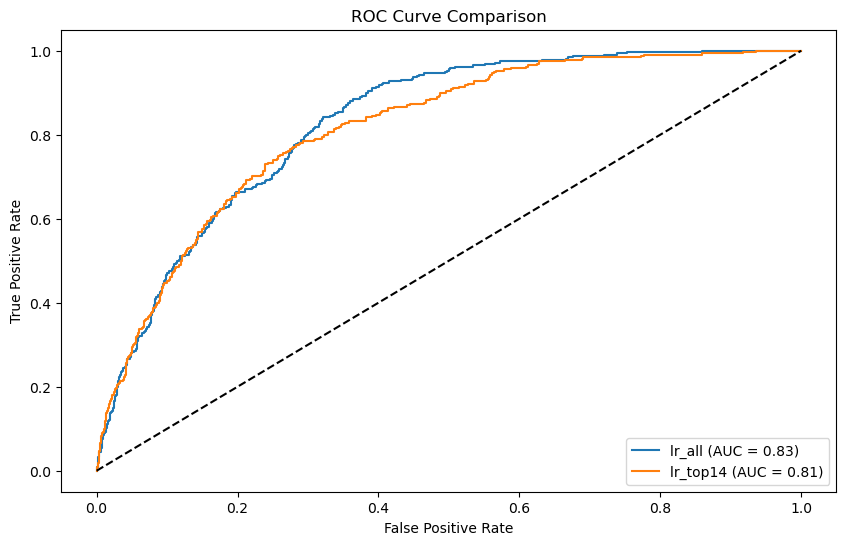

In [45]:
models = ['lr_all', 'lr_top14']
predicted_values = [lr_all_y_prob, lr_top14_y_prob]
labels = ['lr_all', 'lr_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

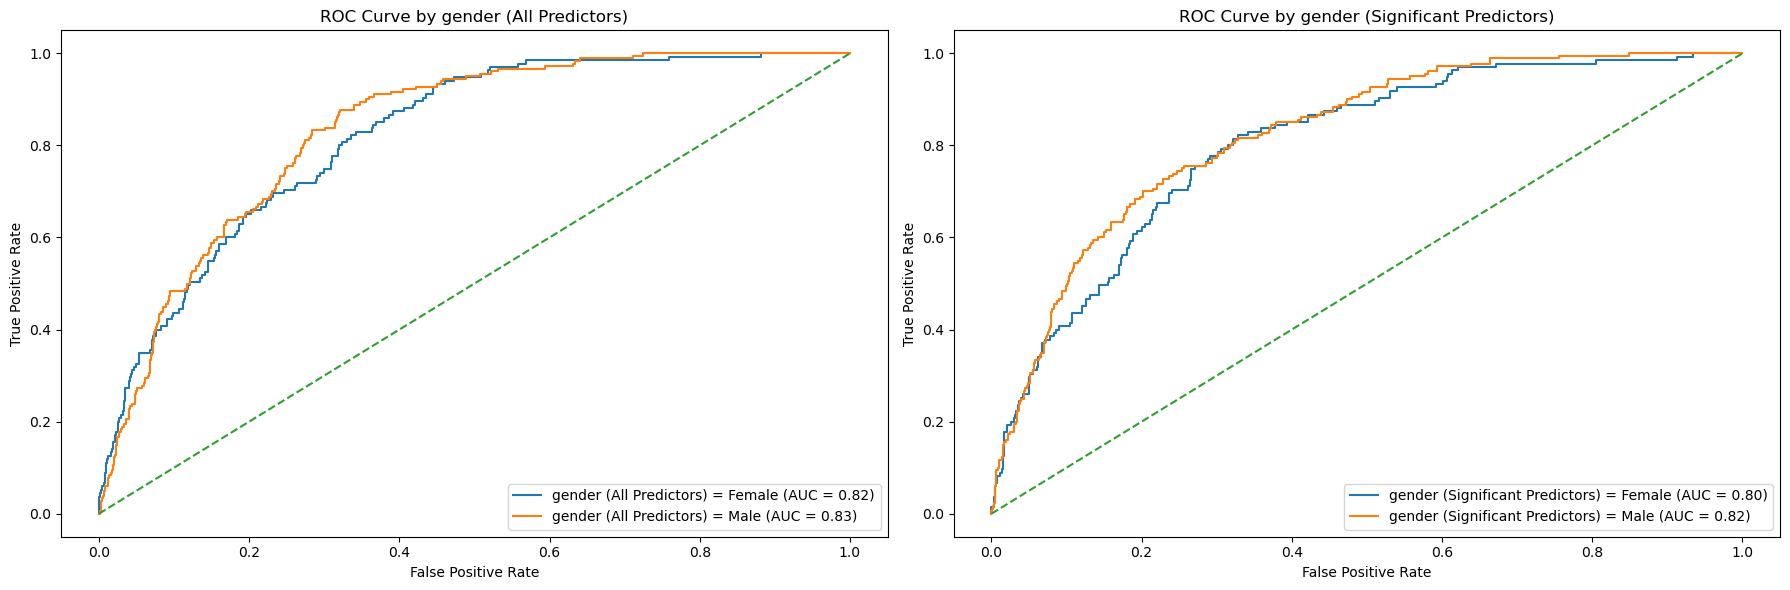

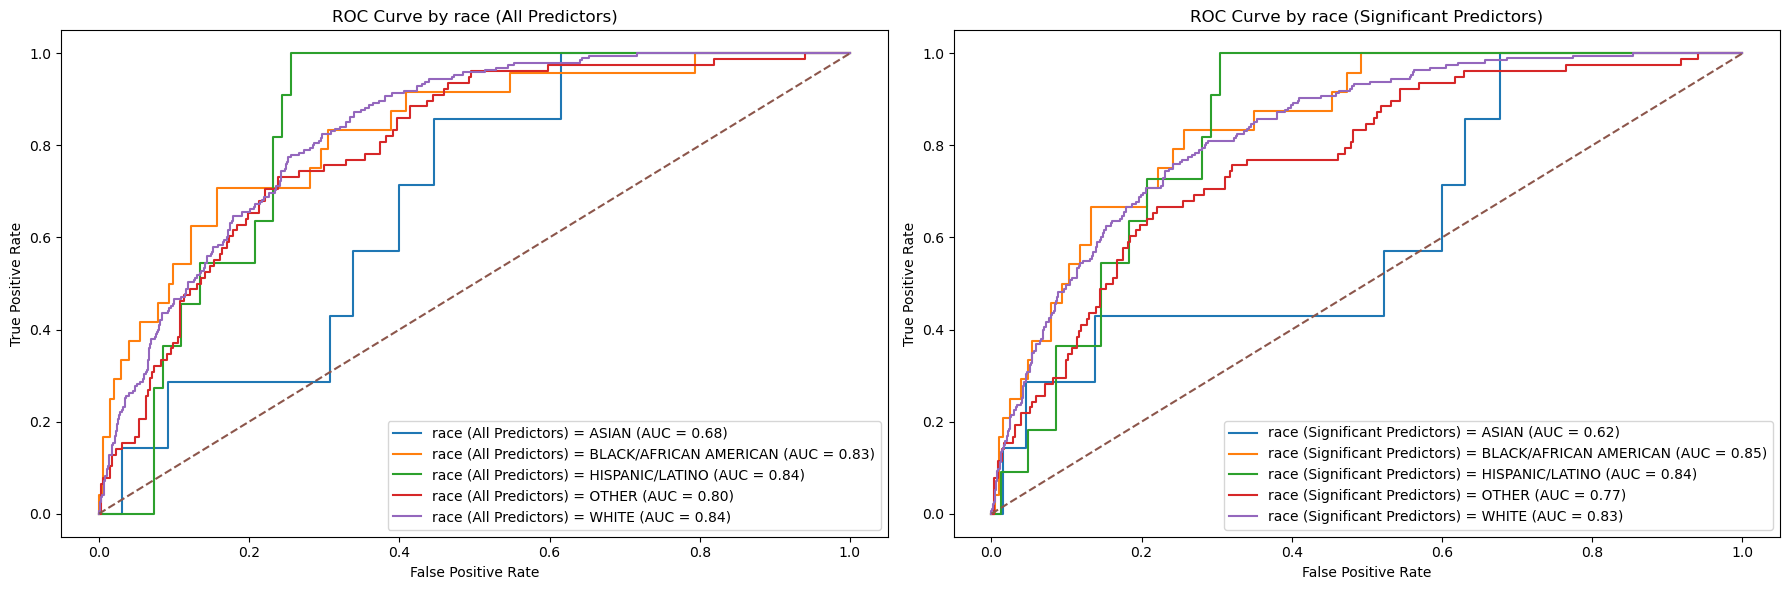

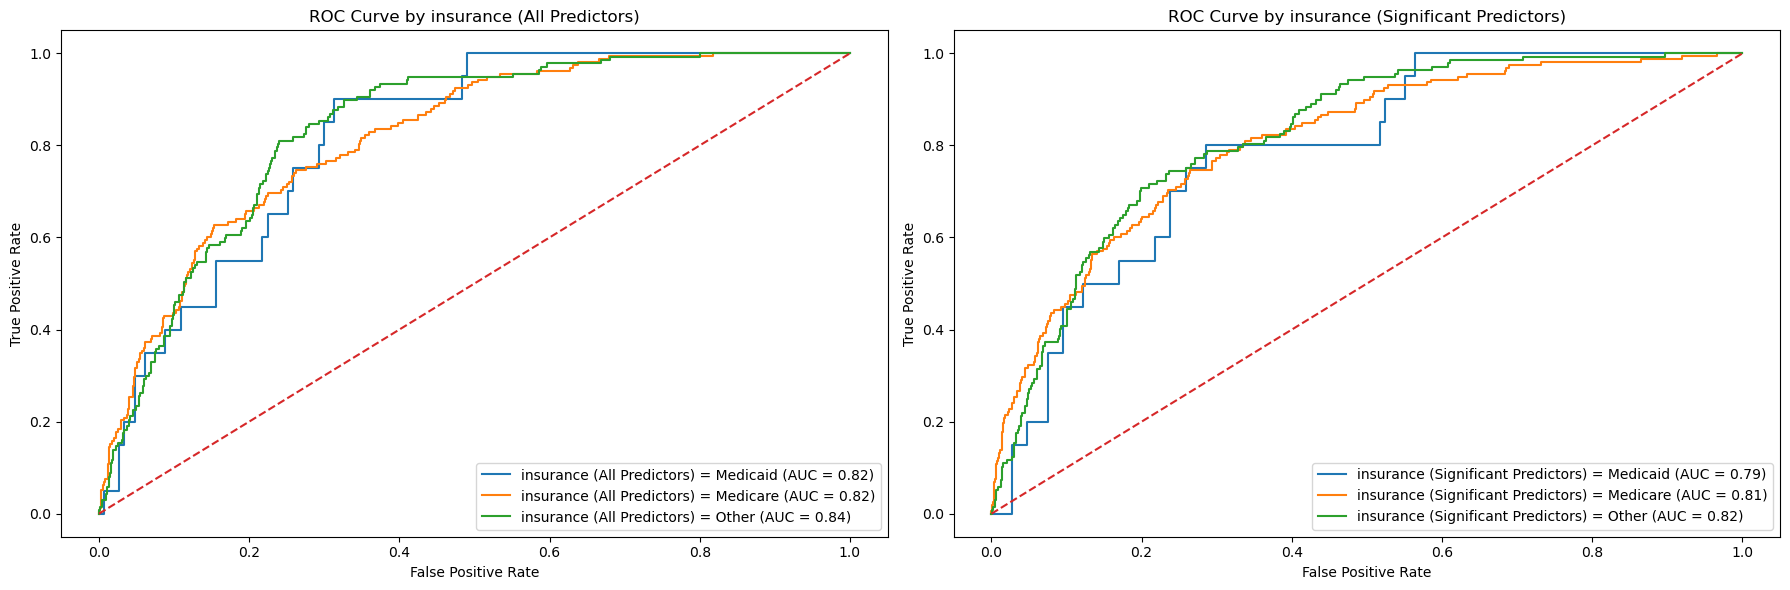

In [46]:
plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, lr_all_y_prob, lr_top14_y_prob, protected_variables)

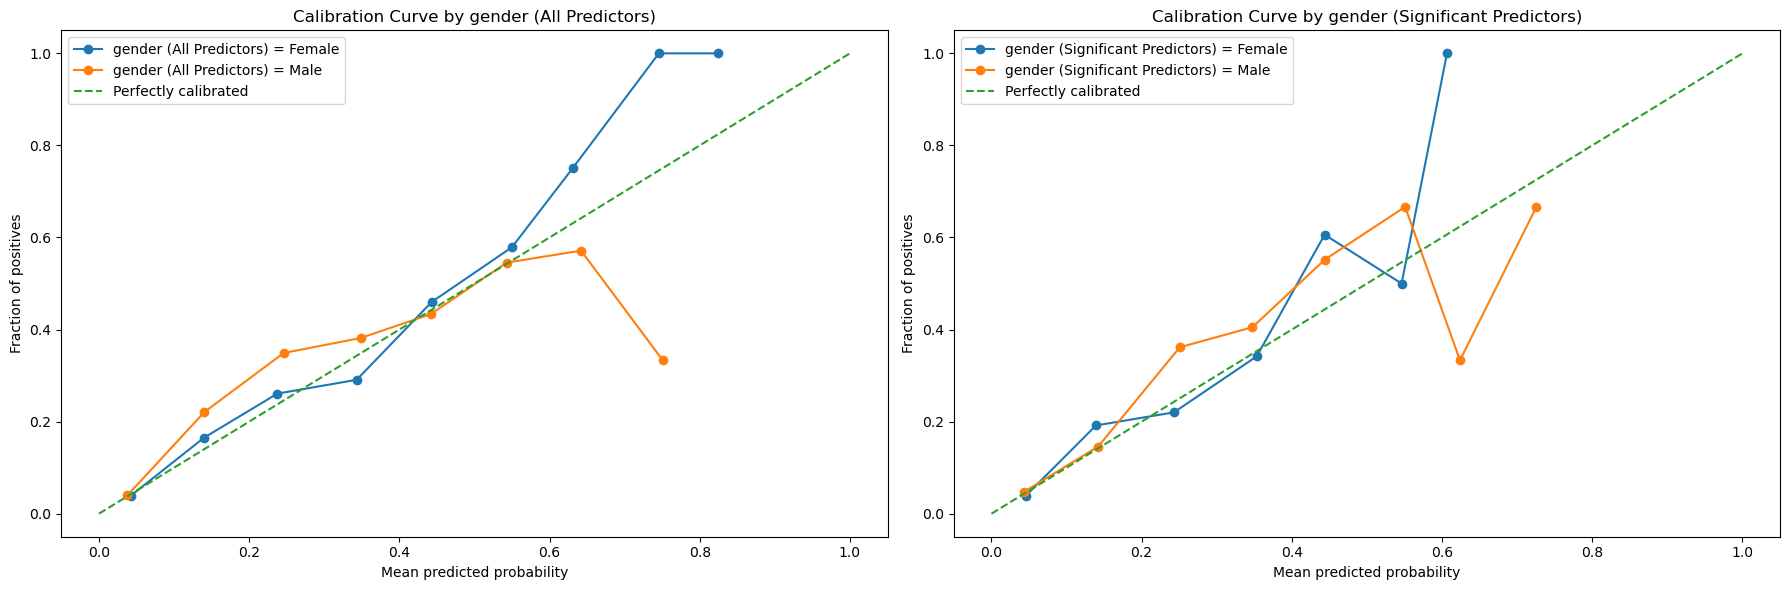

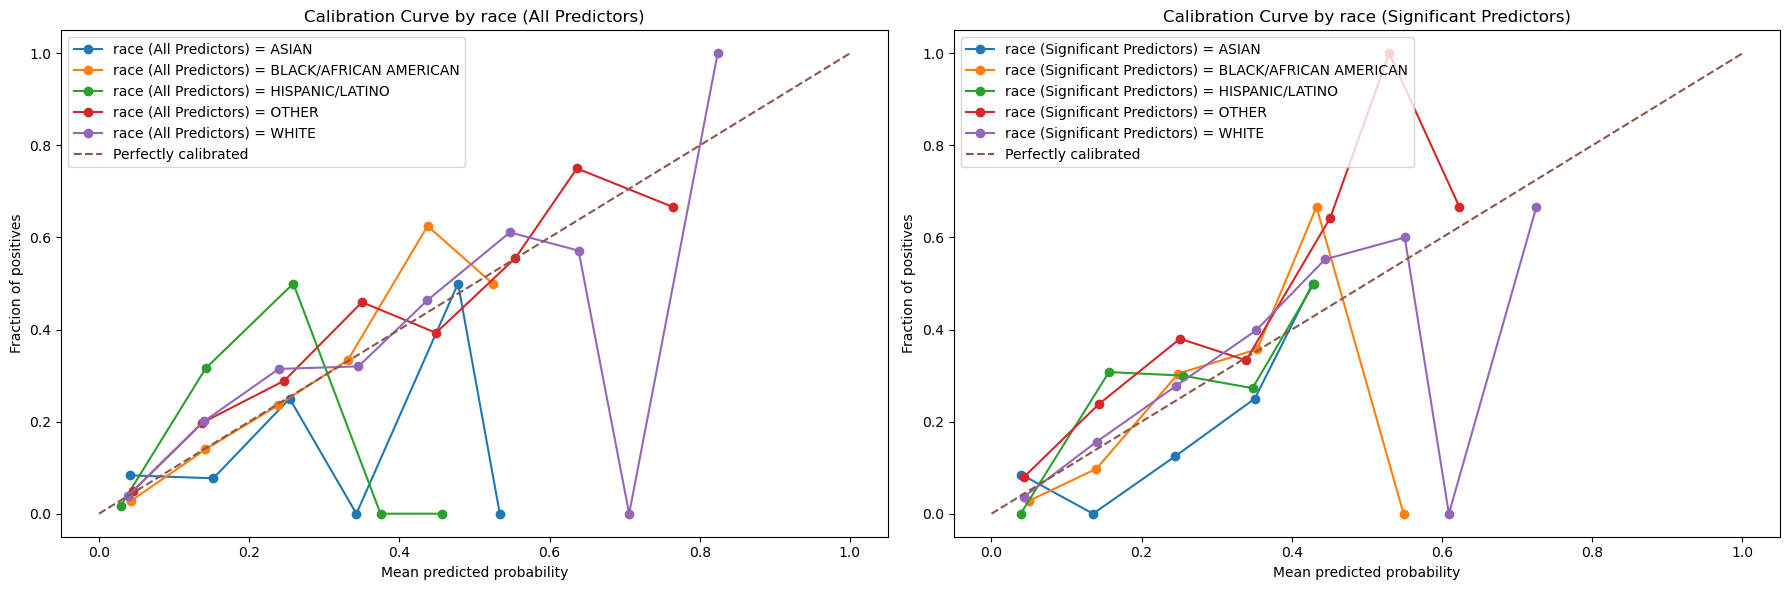

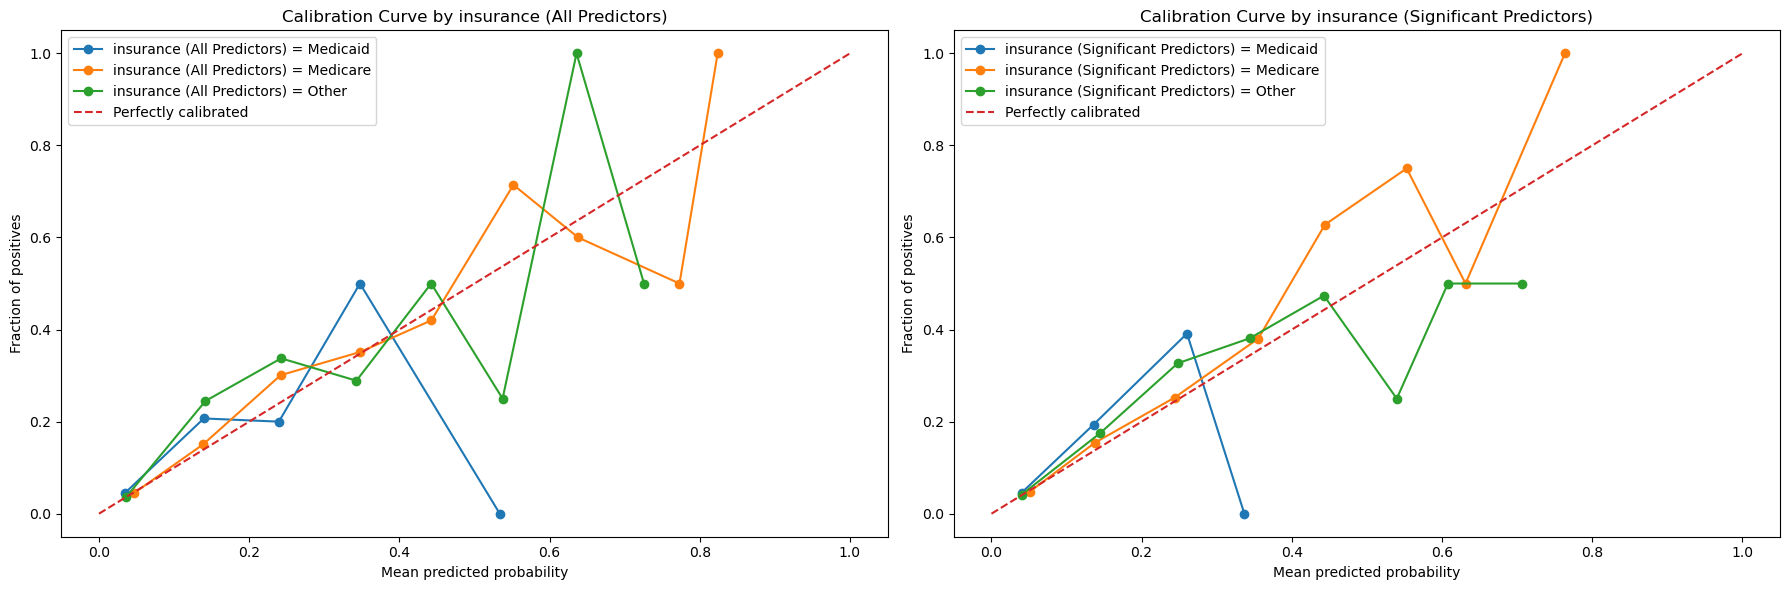

In [47]:
plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, lr_all_y_prob, lr_top14_y_prob, protected_variables)

In [48]:
calculate_equalized_odds_difference(y_test, lr_all_y_pred, lr_top14_y_pred, icu_data, X_test, protected_variables)


Equalized Odds Difference by Gender for Model with All Predictors:
0.057407407407407414

Equalized Odds Difference by Gender for Model with Significant Predictors:
0.009259259259259259

Equalized Odds Difference by Race for Model with All Predictors:
0.1282051282051282

Equalized Odds Difference by Race for Model with Significant Predictors:
0.041025641025641026

Equalized Odds Difference by Insurance for Model with All Predictors:
0.14556962025316456

Equalized Odds Difference by Insurance for Model with Significant Predictors:
0.05063291139240506


## Baseline Logistic Regression + SMOTE Oversampling

In [50]:
# Logistic Regrassion using ALL predictors
lr_smote_all = LogisticRegression(max_iter=1000, solver='liblinear')
lr_smote_all.fit(X_train_resampled, y_train_resampled)

lr_smote_all_y_prob = lr_smote_all.predict_proba(X_test)[:, 1]
lr_smote_all_y_pred = (lr_smote_all_y_prob > 0.5).astype(int)
lr_smote_all_accuracy = lr_smote_all.score(X_test, y_test)
print("Test Accuracy (All Predictors):", lr_smote_all_accuracy)

print("Overall Classification Report for All Predictors:")
print(classification_report(y_test, lr_smote_all_y_pred))

# Logistic Regrassion using ONLY significant predictors
lr_smote_top14 = LogisticRegression(max_iter=1000, solver='liblinear')
lr_smote_top14.fit(X_train_significant_resampled, y_train_significant_resampled)

lr_smote_top14_y_prob = lr_smote_top14.predict_proba(X_test_significant)[:, 1]
lr_smote_top14_y_pred = (lr_smote_top14_y_prob > 0.5).astype(int)
lr_smote_top14_accuracy = lr_smote_top14.score(X_test_significant, y_test)
print("Test Accuracy for Significant Predictors:", lr_smote_top14_accuracy)

print("Overall Classification Report for Significant Predictors:")
print(classification_report(y_test, lr_smote_top14_y_pred))

Test Accuracy (All Predictors): 0.8614107883817428
Overall Classification Report for All Predictors:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2095
           1       0.45      0.26      0.33       315

    accuracy                           0.86      2410
   macro avg       0.67      0.60      0.62      2410
weighted avg       0.84      0.86      0.84      2410

Test Accuracy for Significant Predictors: 0.8099585062240664
Overall Classification Report for Significant Predictors:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89      2095
           1       0.36      0.58      0.44       315

    accuracy                           0.81      2410
   macro avg       0.65      0.71      0.66      2410
weighted avg       0.86      0.81      0.83      2410



In [51]:
generate_classification_reports(icu_data, X_test, y_test, lr_smote_all_y_pred, lr_smote_top14_y_pred, protected_vars)


Classification Report for gender = Female (All Predictors):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       878
           1       0.46      0.24      0.31       135

    accuracy                           0.86      1013
   macro avg       0.68      0.60      0.62      1013
weighted avg       0.83      0.86      0.84      1013


Classification Report for gender = Female (Significant Predictors):
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       878
           1       0.33      0.58      0.42       135

    accuracy                           0.79      1013
   macro avg       0.63      0.70      0.65      1013
weighted avg       0.85      0.79      0.81      1013


Classification Report for gender = Male (All Predictors):
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1217
           1       0.44      0.27      0.34     

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

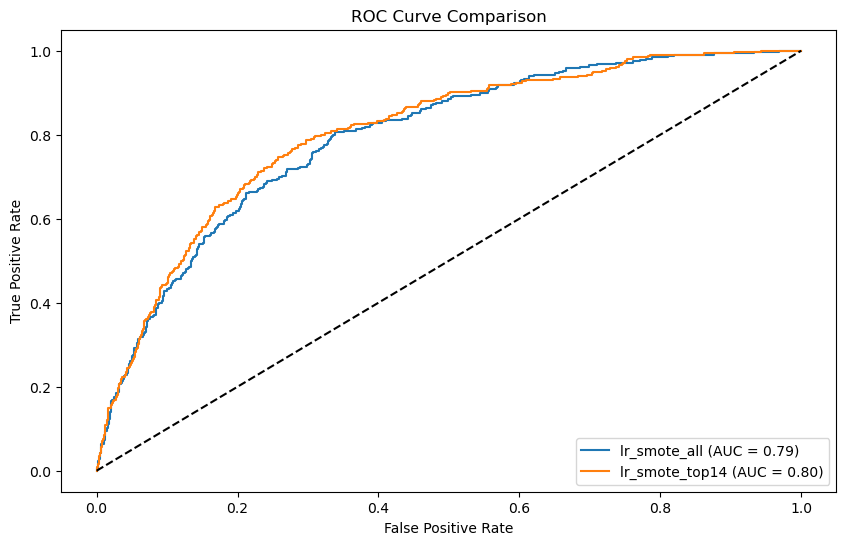

In [52]:
models = ['lr_smote_all', 'lr_smote_top14']
predicted_values = [lr_smote_all_y_prob, lr_smote_top14_y_prob]
labels = ['lr_smote_all', 'lr_smote_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

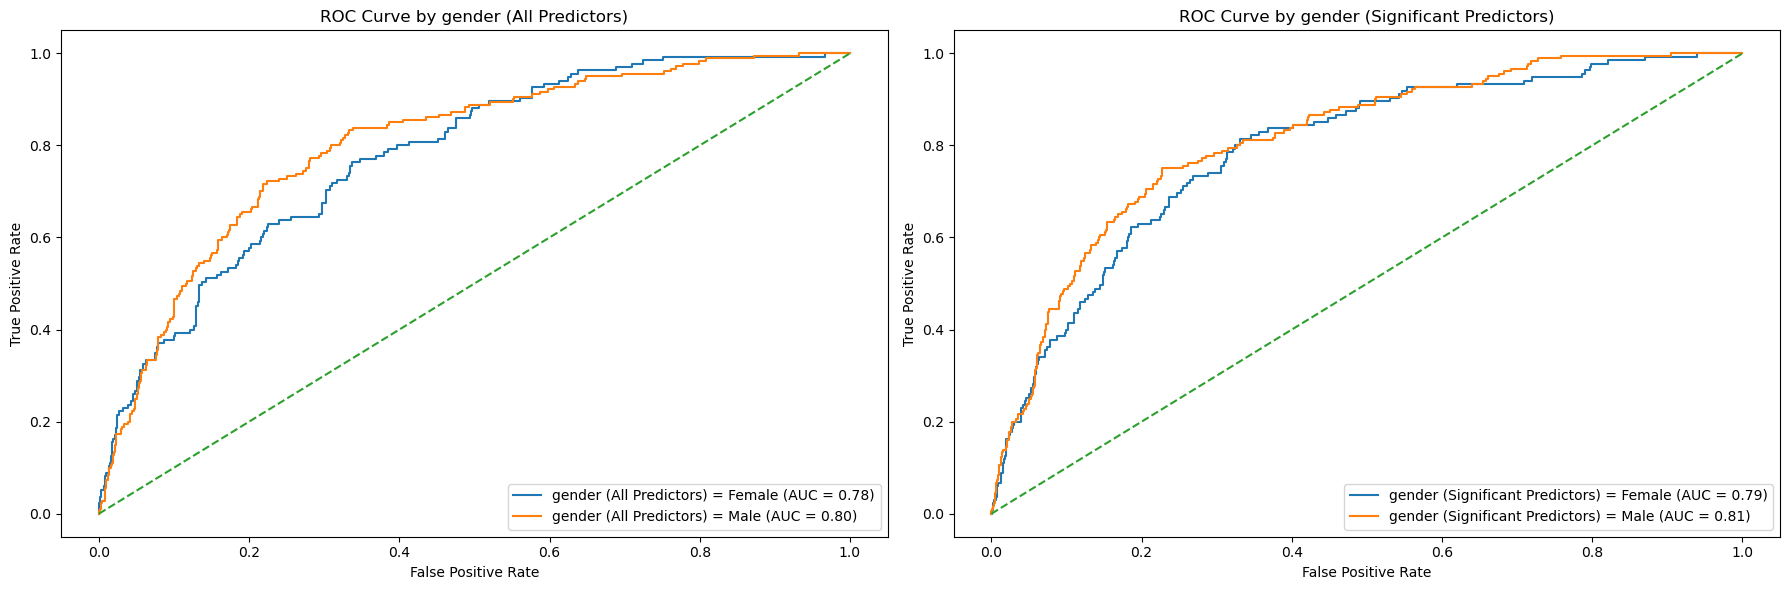

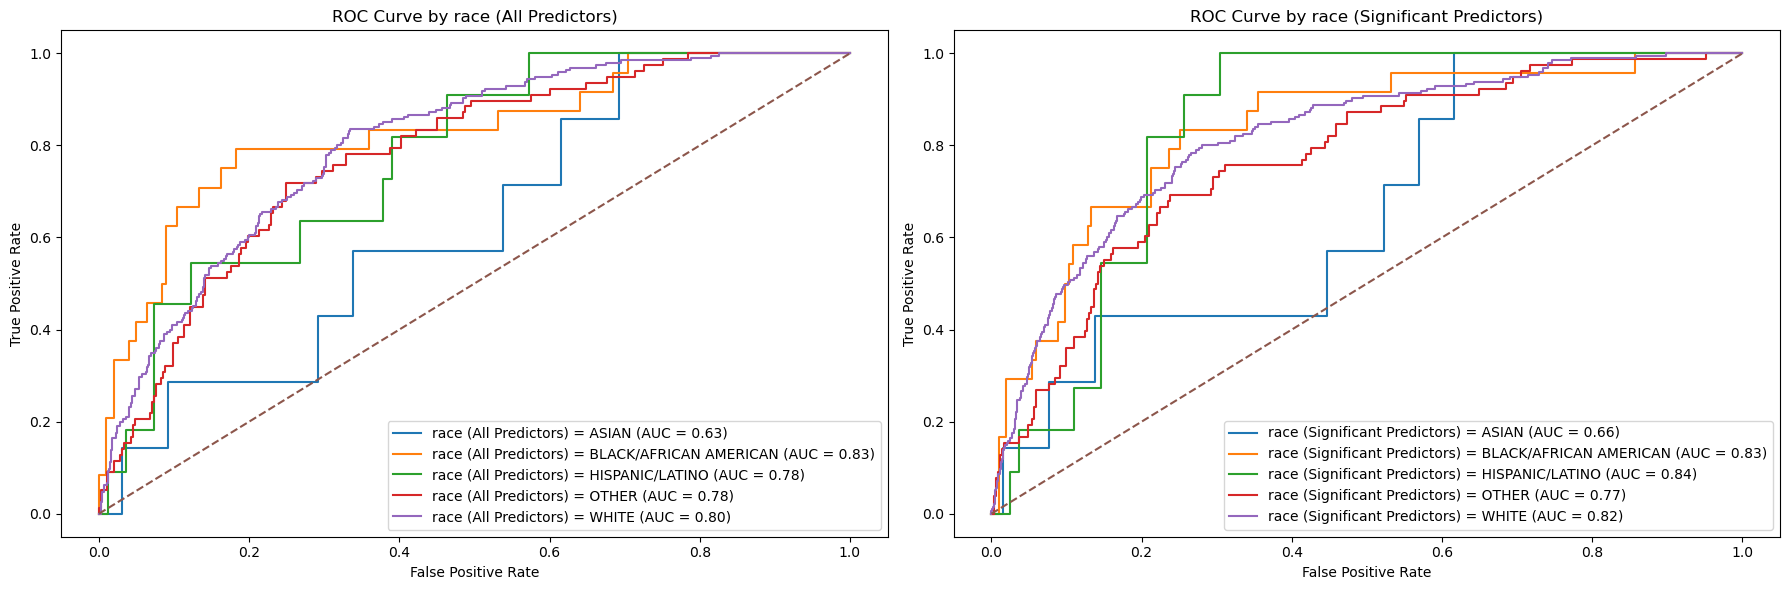

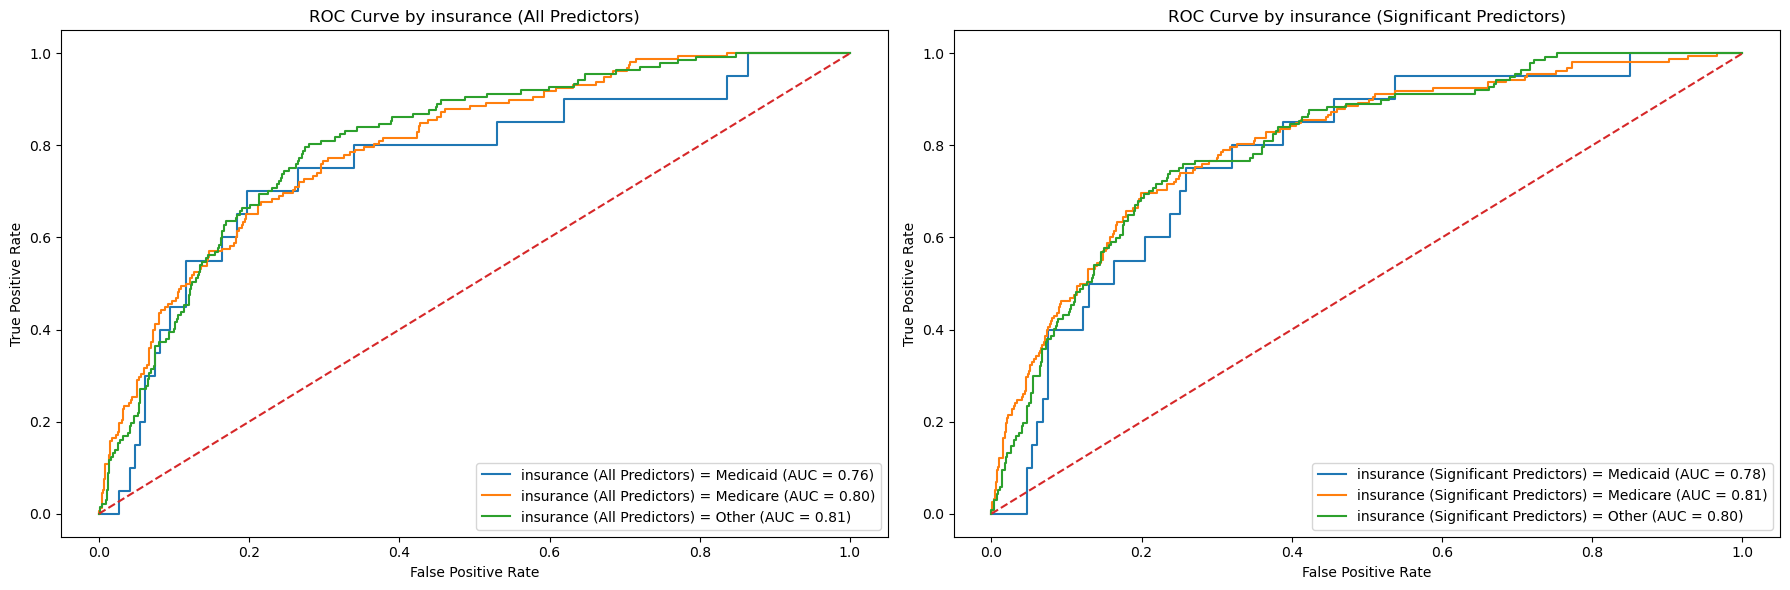

In [53]:
plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, lr_smote_all_y_prob, lr_smote_top14_y_prob, protected_variables)

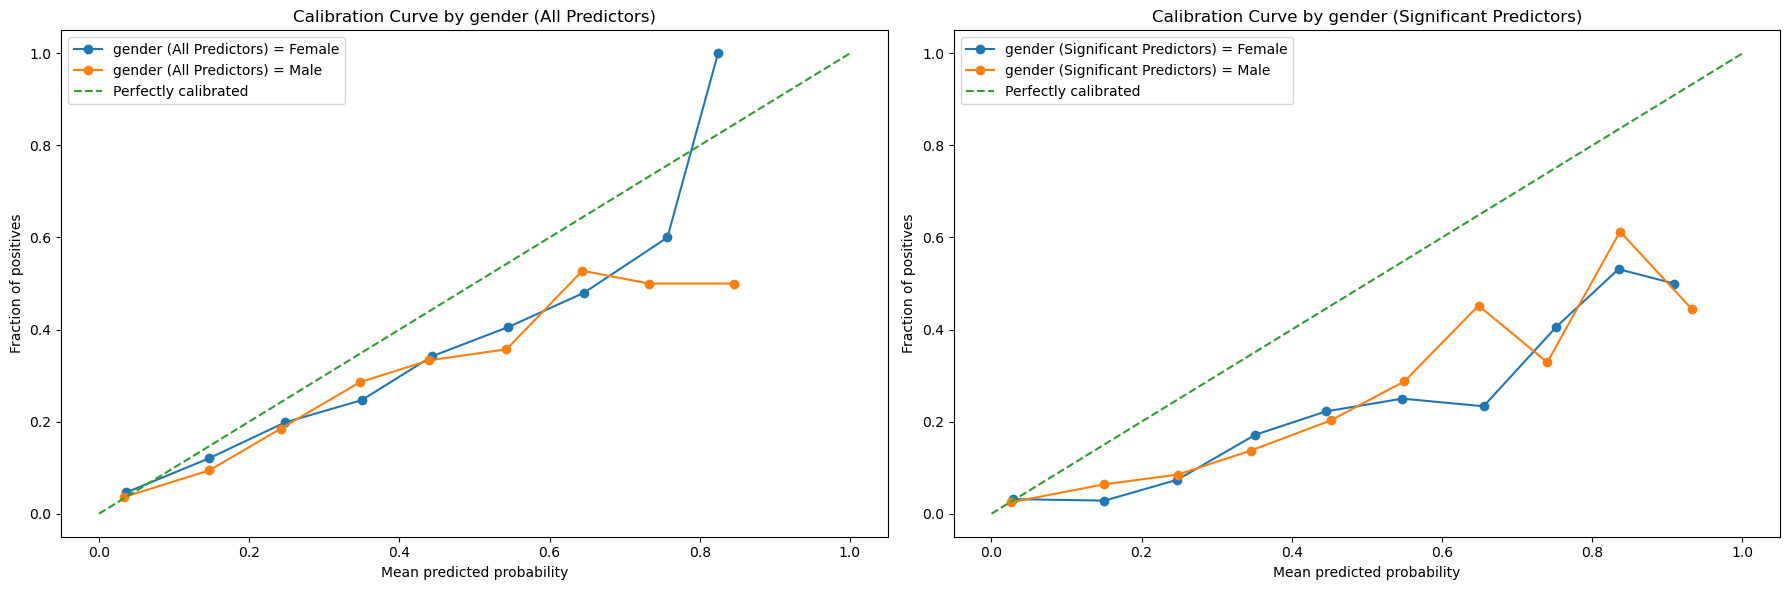

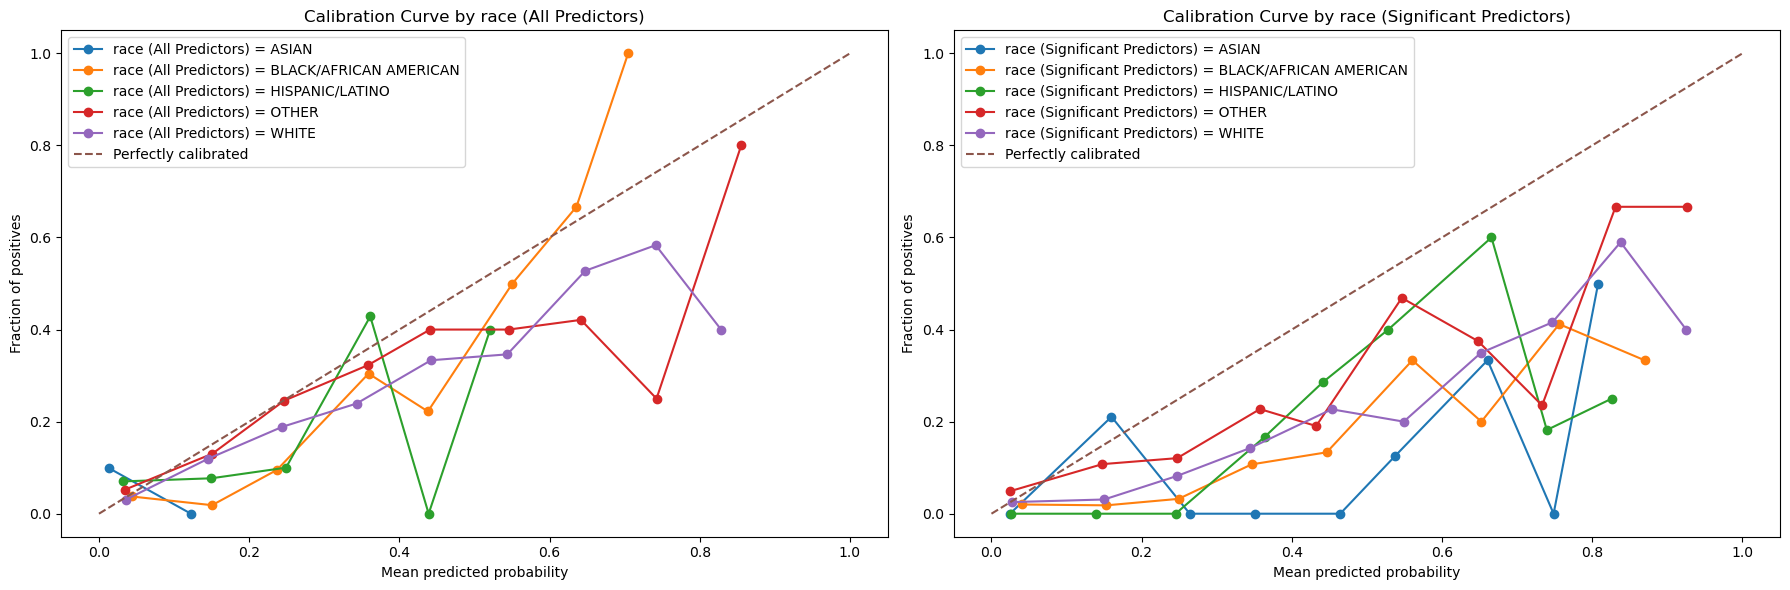

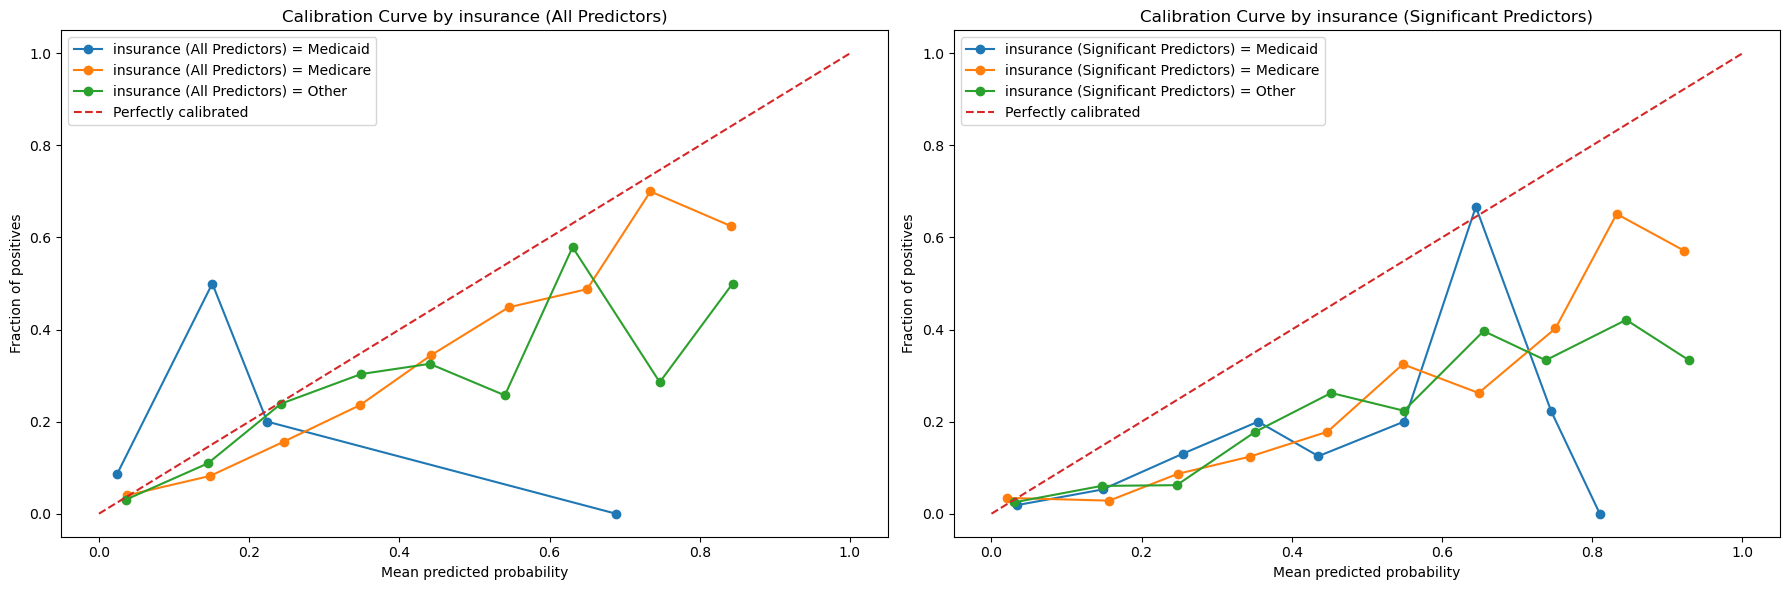

In [54]:
plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, lr_smote_all_y_prob, lr_smote_top14_y_prob, protected_variables)

In [55]:
calculate_equalized_odds_difference(y_test, lr_smote_all_y_pred, lr_smote_top14_y_pred, icu_data, X_test, protected_variables)


Equalized Odds Difference by Gender for Model with All Predictors:
0.03518518518518515

Equalized Odds Difference by Gender for Model with Significant Predictors:
0.04191007050834514

Equalized Odds Difference by Race for Model with All Predictors:
0.3333333333333333

Equalized Odds Difference by Race for Model with Significant Predictors:
0.29870129870129875

Equalized Odds Difference by Insurance for Model with All Predictors:
0.3670886075949367

Equalized Odds Difference by Insurance for Model with Significant Predictors:
0.15822784810126578


## Baseline Logistic Regression + SMOTE Oversampling + Threshold Changing

In [58]:
from sklearn.metrics import precision_recall_curve

def find_optimal_threshold(y_true, y_prob, epsilon=1e-6):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    if len(precision) == 0 or len(recall) == 0:
        return 0.5  
    f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

optimal_thresholds_all = {}
optimal_thresholds_significant = {}
protected_variables = ['gender', 'race', 'insurance']

icu_test_data = icu_data.loc[y_test.index]

for var in protected_variables:
    optimal_thresholds_all[var] = {}
    optimal_thresholds_significant[var] = {}
    for group in icu_test_data[var].unique():
        mask = (icu_test_data[var] == group)
        
        # For all predictors model
        y_true_group_all = y_test[mask]
        y_prob_group_all = lr_smote_all_y_prob[mask]
        if len(y_true_group_all) == 0 or len(y_prob_group_all) == 0:
            optimal_thresholds_all[var][group] = 0.5  
        else:
            optimal_thresholds_all[var][group] = find_optimal_threshold(y_true_group_all, y_prob_group_all)
        
        # For significant predictors model
        y_true_group_significant = y_test[mask]
        y_prob_group_significant = lr_smote_top14_y_prob[mask]
        if len(y_true_group_significant) == 0 or len(y_prob_group_significant) == 0:
            optimal_thresholds_significant[var][group] = 0.5  
        else:
            optimal_thresholds_significant[var][group] = find_optimal_threshold(y_true_group_significant, y_prob_group_significant)

        print(f"Optimal threshold for {var} = {group} (All Predictors): {optimal_thresholds_all[var][group]}")
        print(f"Optimal threshold for {var} = {group} (Significant Predictors): {optimal_thresholds_significant[var][group]}")

def apply_thresholds(y_prob, icu_test_data, optimal_thresholds, protected_variables):
    y_pred_adjusted = np.zeros_like(y_prob, dtype=int)
    for var in protected_variables:
        for group, threshold in optimal_thresholds[var].items():
            mask = (icu_test_data[var] == group)
            y_pred_adjusted[mask] = (y_prob[mask] > threshold).astype(int)
    return y_pred_adjusted

Optimal threshold for gender = Female (All Predictors): 0.2951731226098372
Optimal threshold for gender = Female (Significant Predictors): 0.4732348096334829
Optimal threshold for gender = Male (All Predictors): 0.22842660802463277
Optimal threshold for gender = Male (Significant Predictors): 0.4712434247880919
Optimal threshold for race = WHITE (All Predictors): 0.28414102814777653
Optimal threshold for race = WHITE (Significant Predictors): 0.6174881782858896
Optimal threshold for race = OTHER (All Predictors): 0.2356398499431678
Optimal threshold for race = OTHER (Significant Predictors): 0.372743780676278
Optimal threshold for race = ASIAN (All Predictors): 0.03394281387899109
Optimal threshold for race = ASIAN (Significant Predictors): 0.5313599390446473
Optimal threshold for race = HISPANIC/LATINO (All Predictors): 0.3577056328408005
Optimal threshold for race = HISPANIC/LATINO (Significant Predictors): 0.48283800506523156
Optimal threshold for race = BLACK/AFRICAN AMERICAN (All 

In [70]:
# Apply the optimal thresholds to the test data for all predictors model
lr_smote_all_y_pred_adjusted = apply_thresholds(lr_smote_all_y_prob, icu_test_data, optimal_thresholds_all, protected_variables)

print("Overall Classification Report for All Predictors (Adjusted Thresholds):")
print(classification_report(y_test, lr_smote_all_y_pred_adjusted))

# Apply the optimal thresholds to the test data for significant predictors model
lr_smote_top14_y_pred_adjusted = apply_thresholds(lr_smote_top14_y_prob, icu_test_data, optimal_thresholds_significant, protected_variables)

print("Overall Classification Report for Significant Predictors (Adjusted Thresholds):")
print(classification_report(y_test, lr_smote_top14_y_pred_adjusted))


Overall Classification Report for All Predictors (Adjusted Thresholds):
              precision    recall  f1-score   support

           0       0.93      0.84      0.89      2095
           1       0.36      0.59      0.45       315

    accuracy                           0.81      2410
   macro avg       0.65      0.72      0.67      2410
weighted avg       0.86      0.81      0.83      2410

Overall Classification Report for Significant Predictors (Adjusted Thresholds):
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      2095
           1       0.34      0.68      0.45       315

    accuracy                           0.79      2410
   macro avg       0.64      0.74      0.66      2410
weighted avg       0.86      0.79      0.81      2410



In [73]:
def adjusted_probs(y_prob, icu_test_data, optimal_thresholds, protected_variables):
    y_prob_adjusted = np.zeros_like(y_prob)
    for var in protected_variables:
        for group, threshold in optimal_thresholds[var].items():
            mask = (icu_test_data[var] == group)
            y_prob_adjusted[mask] = y_prob[mask] / threshold
            y_prob_adjusted[mask] = np.clip(y_prob_adjusted[mask], 0, 1)  # Ensure probabilities are between 0 and 1
    return y_prob_adjusted

In [74]:
# Convert adjusted predictions back into probabilities for all predictors model
lr_smote_all_y_prob_adjusted = adjusted_probs(lr_smote_all_y_prob, icu_test_data, optimal_thresholds_all, protected_variables)

# Convert adjusted predictions back into probabilities for significant predictors model
lr_smote_top14_y_prob_adjusted = adjusted_probs(lr_smote_top14_y_prob, icu_test_data, optimal_thresholds_significant, protected_variables)

In [71]:
generate_classification_reports(icu_data, X_test, y_test, lr_smote_all_y_pred_adjusted, lr_smote_top14_y_pred_adjusted, protected_vars)


Classification Report for gender = Female (All Predictors):
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       878
           1       0.37      0.51      0.43       135

    accuracy                           0.82      1013
   macro avg       0.64      0.69      0.66      1013
weighted avg       0.85      0.82      0.83      1013


Classification Report for gender = Female (Significant Predictors):
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       878
           1       0.32      0.67      0.43       135

    accuracy                           0.77      1013
   macro avg       0.63      0.73      0.64      1013
weighted avg       0.86      0.77      0.80      1013


Classification Report for gender = Male (All Predictors):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1217
           1       0.36      0.64      0.46     

C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicka\miniconda3\envs\ssml2024\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

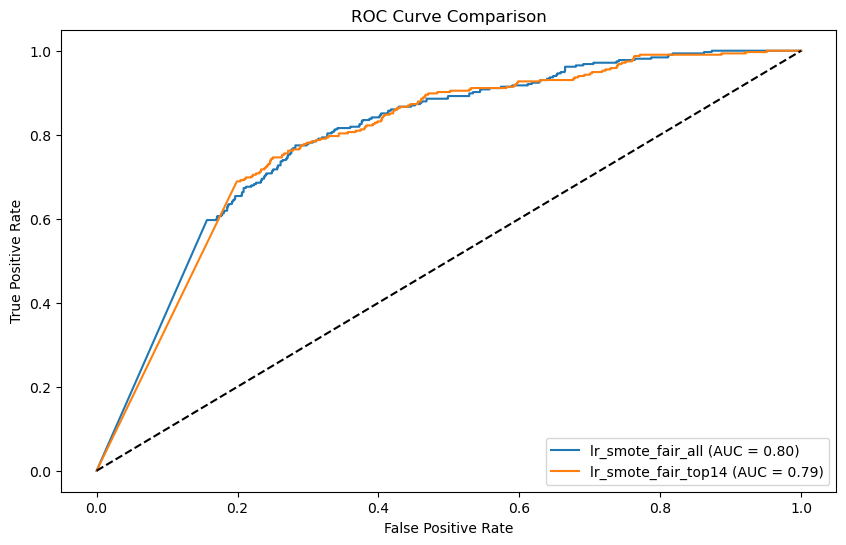

In [75]:
models = ['lr_smote_fair_all', 'lr_smote_fair_top14']
predicted_values = [lr_smote_all_y_prob_adjusted, lr_smote_top14_y_prob_adjusted]
labels = ['lr_smote_fair_all', 'lr_smote_fair_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

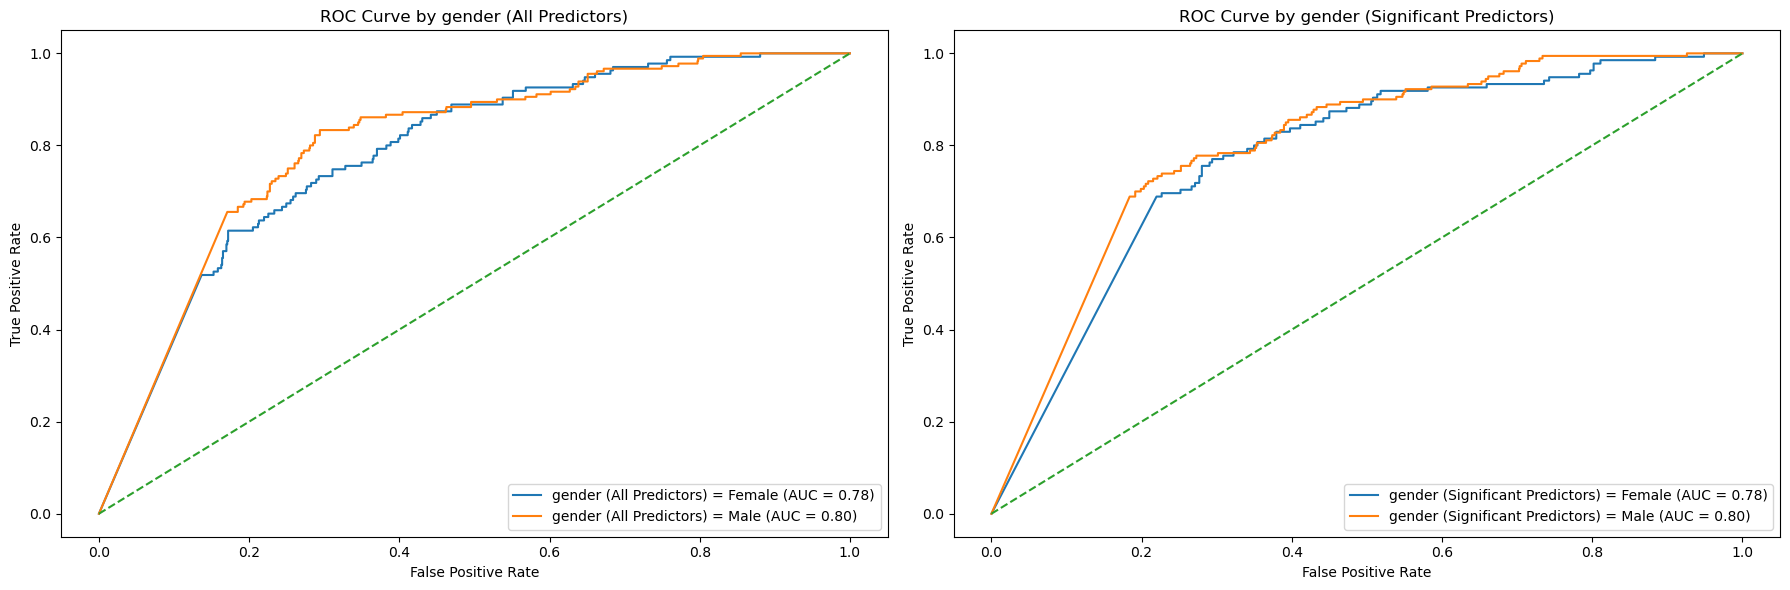

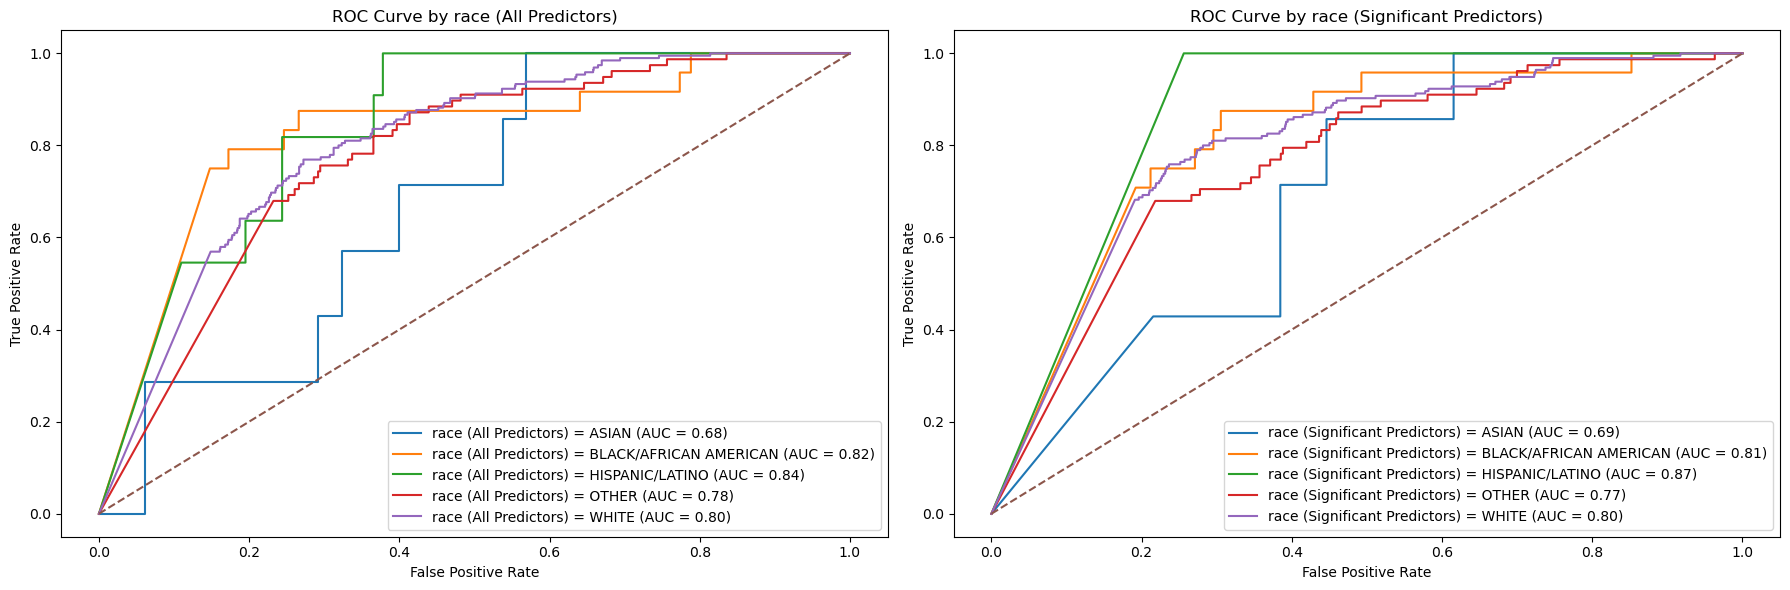

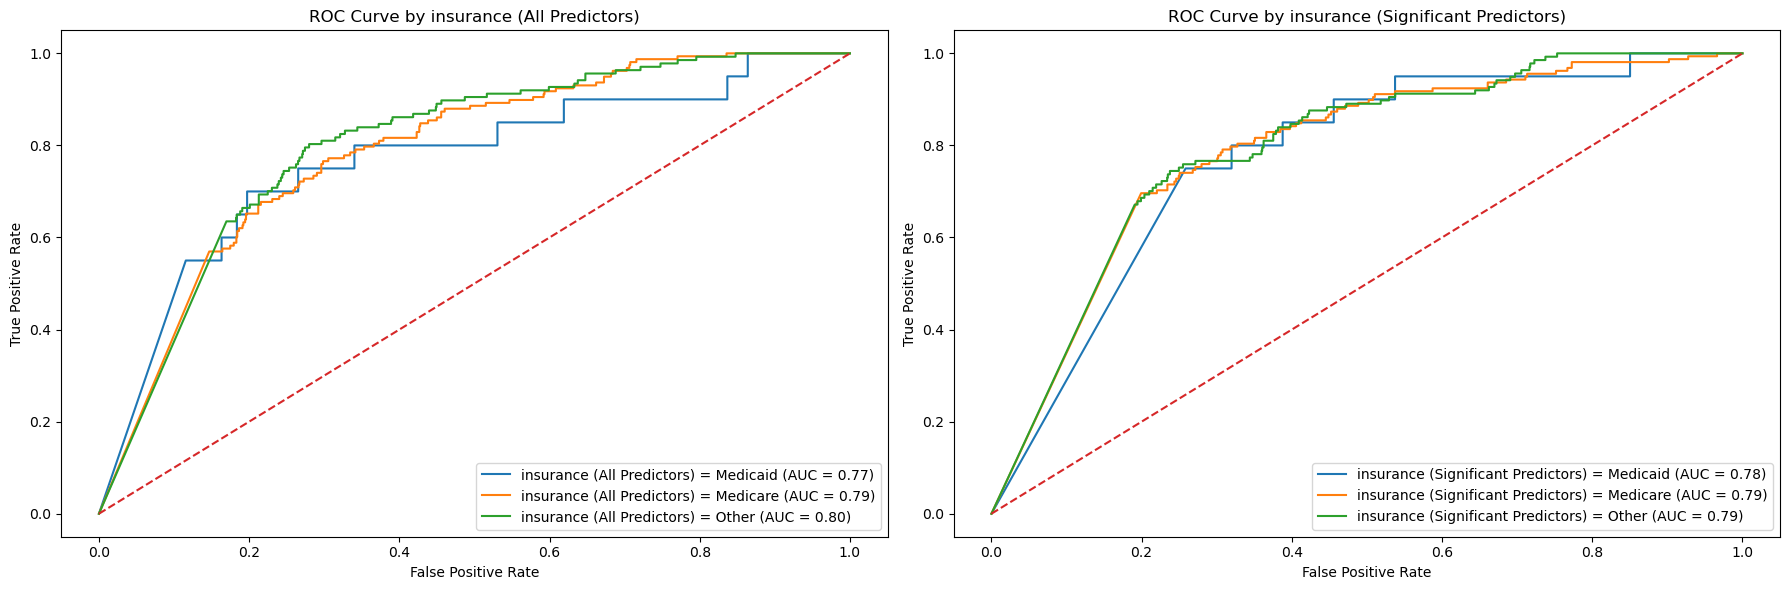

In [76]:
plot_roc_curves_by_protected_vars(icu_data, X_test, y_test, lr_smote_all_y_prob_adjusted, lr_smote_top14_y_prob_adjusted, protected_variables)

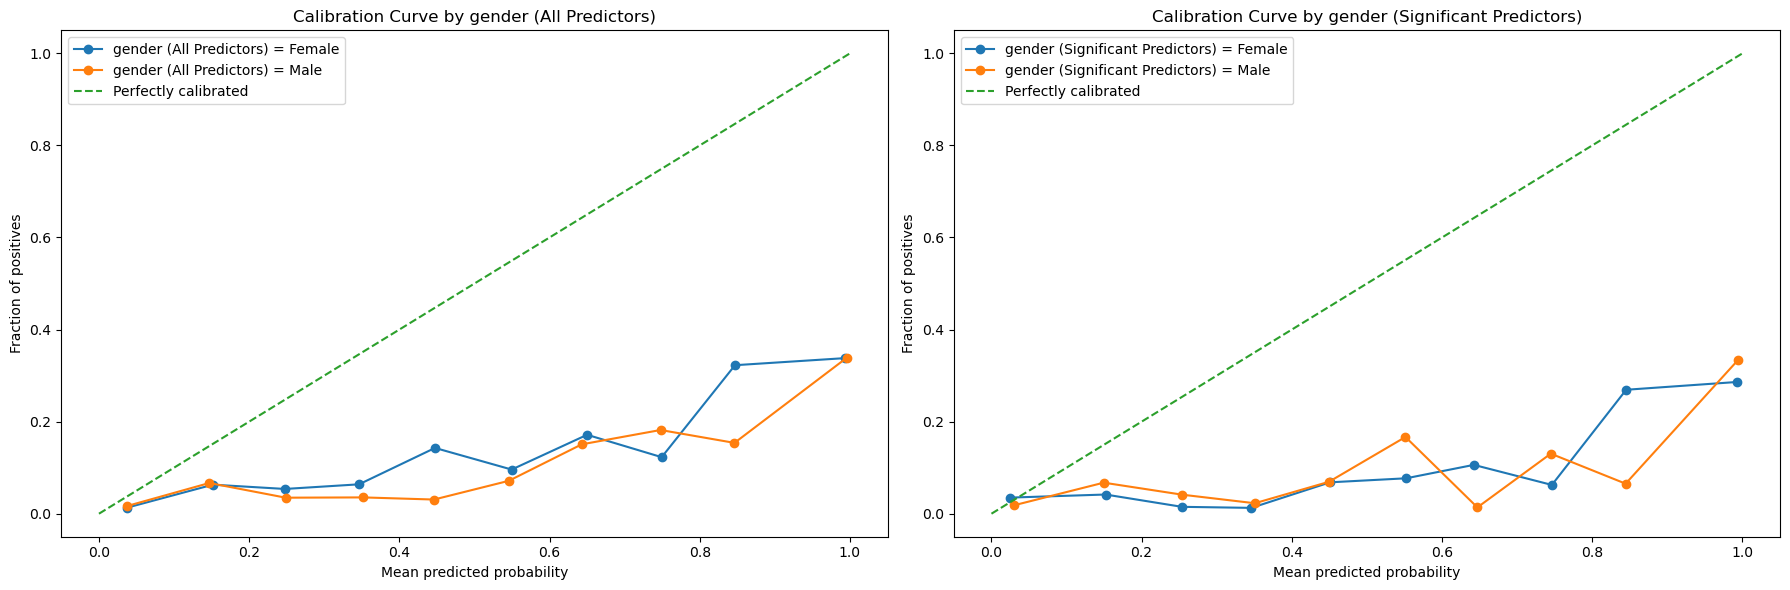

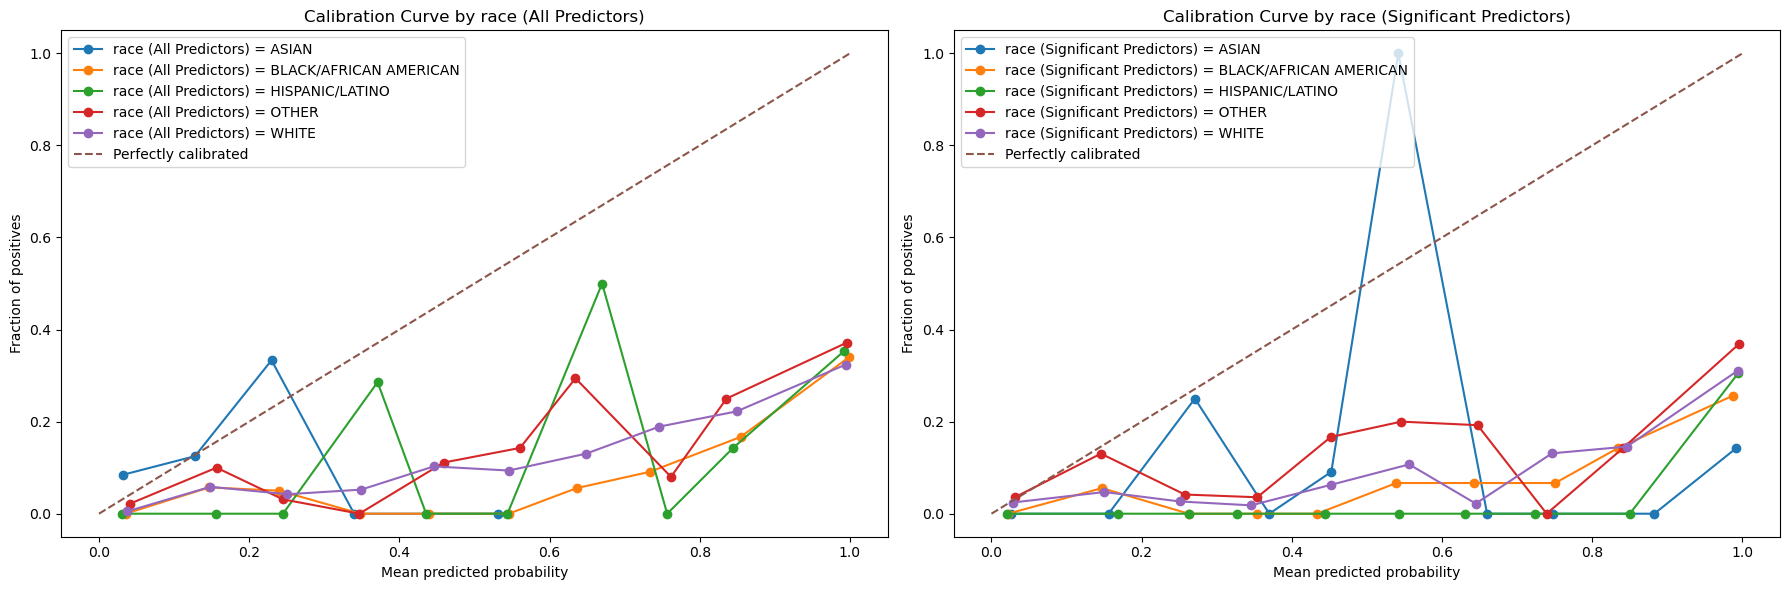

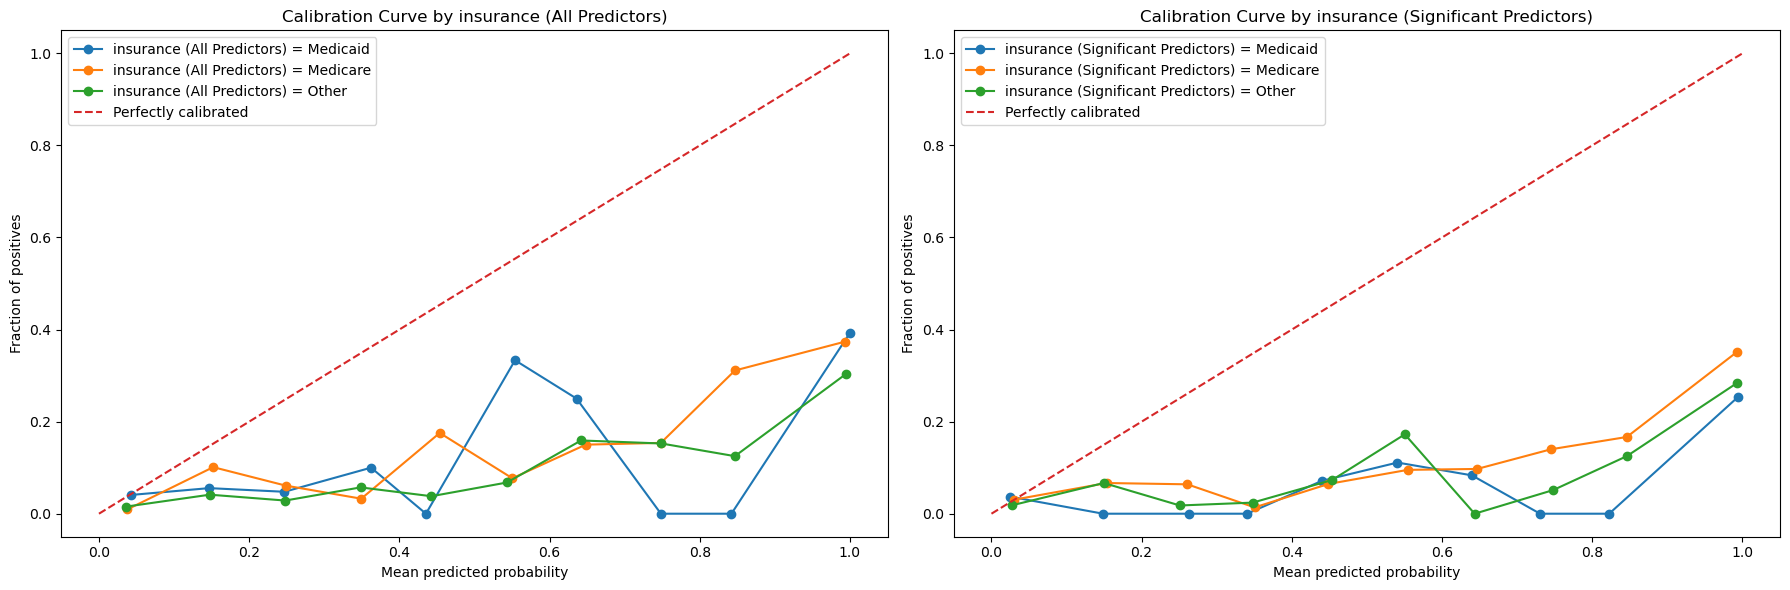

In [77]:
plot_calibration_curves_by_protected_vars(icu_data, X_test, y_test, lr_smote_all_y_prob_adjusted, lr_smote_top14_y_prob_adjusted, protected_variables)

In [72]:
calculate_equalized_odds_difference(y_test, lr_smote_all_y_pred_adjusted, lr_smote_top14_y_pred_adjusted, icu_data, X_test, protected_variables)


Equalized Odds Difference by Gender for Model with All Predictors:
0.13333333333333341

Equalized Odds Difference by Gender for Model with Significant Predictors:
0.03575860578029921

Equalized Odds Difference by Race for Model with All Predictors:
0.7083333333333334

Equalized Odds Difference by Race for Model with Significant Predictors:
0.5714285714285714

Equalized Odds Difference by Insurance for Model with All Predictors:
0.12773722627737227

Equalized Odds Difference by Insurance for Model with Significant Predictors:
0.06767771328714972


## Plots

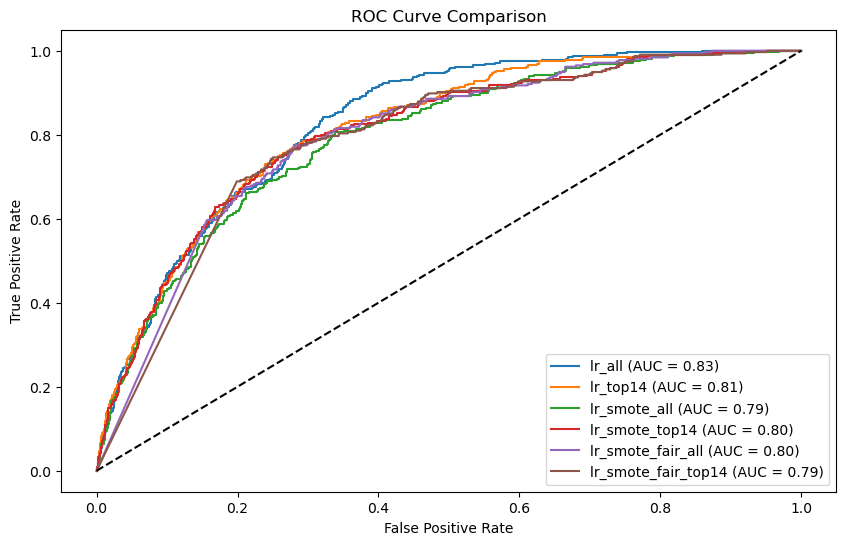

In [78]:
models = ['lr_all', 'lr_top14', 'lr_smote_all', 'lr_smote_top14', 'lr_smote_fair_all', 'lr_smote_fair_top14']
predicted_values = [lr_all_y_prob, lr_top14_y_prob, 
                    lr_smote_all_y_prob, lr_smote_top14_y_prob,
                    lr_smote_all_y_prob_adjusted, lr_smote_top14_y_prob_adjusted]
labels = ['lr_all', 'lr_top14', 'lr_smote_all', 'lr_smote_top14', 'lr_smote_fair_all', 'lr_smote_fair_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

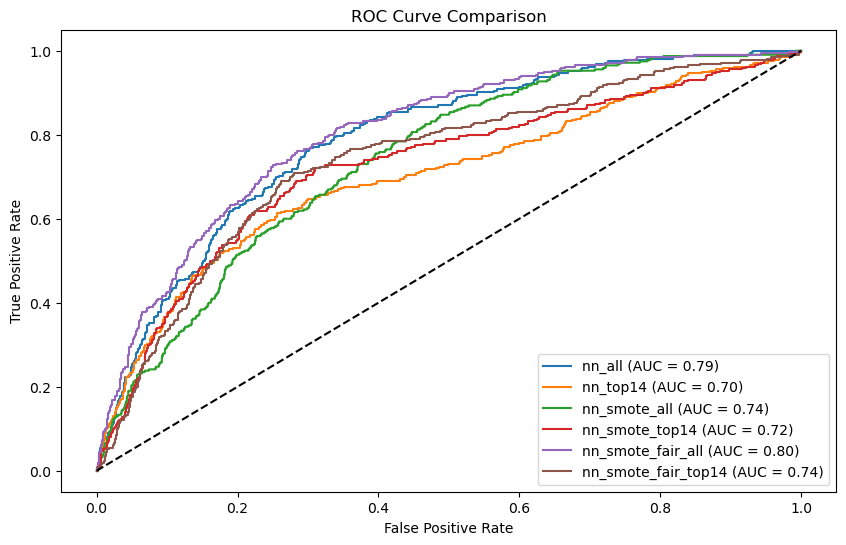

In [79]:
models = ['nn_all', 'nn_top14', 'nn_smote_all', 'nn_smote_top14', 'nn_smote_fair_all', 'nn_smote_fair_top14']
predicted_values = [nn_all_y_prob, nn_top14_y_prob, 
                    nn_smote_all_y_prob, nn_smote_top14_y_prob,
                    nn_smote_fair_all_y_prob, nn_smote_fair_top14_y_prob]
labels = ['nn_all', 'nn_top14', 'nn_smote_all', 'nn_smote_top14', 'nn_smote_fair_all', 'nn_smote_fair_top14']

plot_roc_curves(models, y_test, predicted_values, labels)

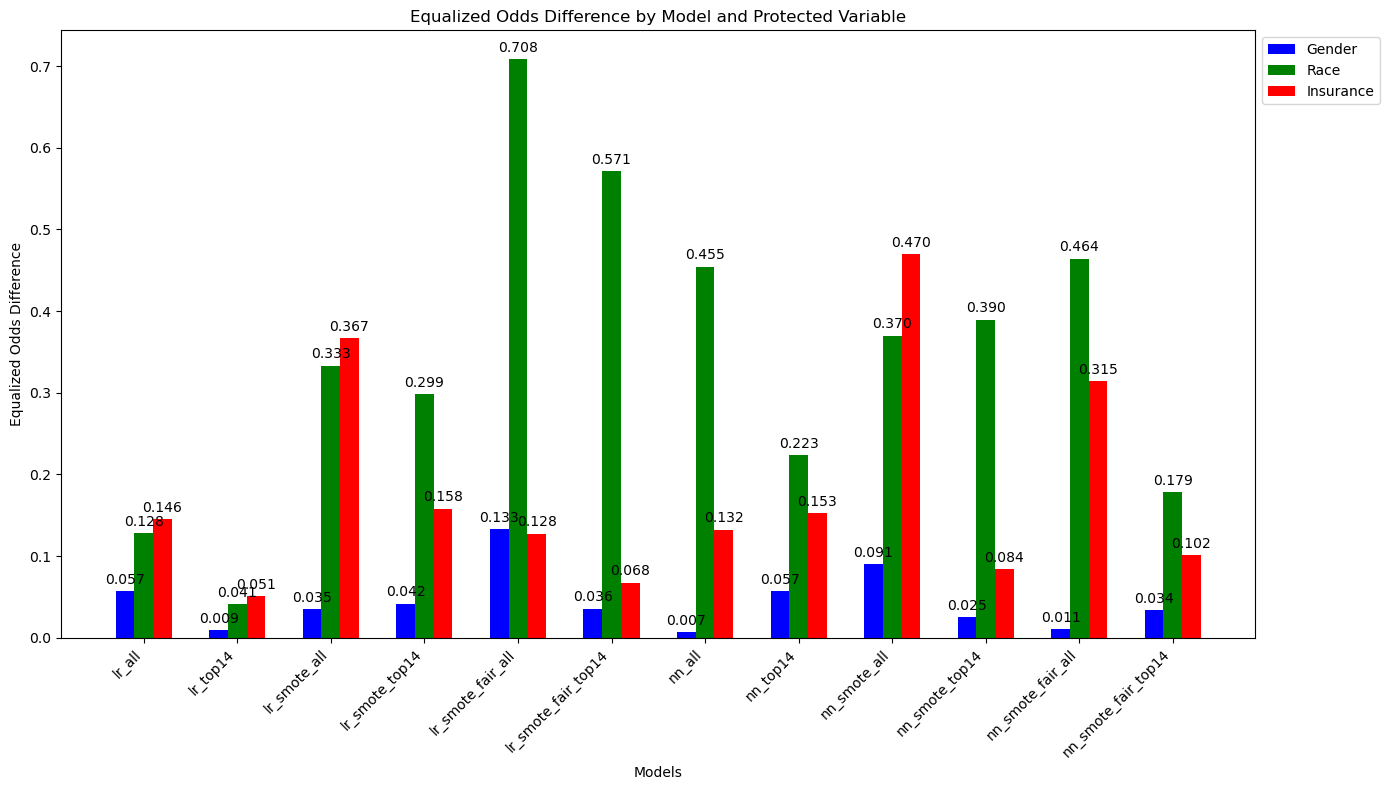

In [89]:
def calculate_equalized_odds_difference_plot(models, y_test, icu_data, X_test, protected_variables):
    eo_diffs = {model: {var: 0 for var in protected_variables} for model in models}
    
    for model, y_pred in models.items():
        for var in protected_variables:
            eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=icu_data.loc[X_test.index, var])
            eo_diffs[model][var] = eo_diff
    
    return eo_diffs

models = {
    'lr_all': lr_all_y_pred,  
    'lr_top14': lr_top14_y_pred,  
    'lr_smote_all': lr_smote_all_y_pred,  
    'lr_smote_top14': lr_smote_top14_y_pred,
    'lr_smote_fair_all': lr_smote_all_y_pred_adjusted,
    'lr_smote_fair_top14': lr_smote_top14_y_pred_adjusted,
    'nn_all': nn_all_y_pred,  
    'nn_top14': nn_top14_y_pred,  
    'nn_smote_all': nn_smote_all_y_pred,  
    'nn_smote_top14': nn_smote_top14_y_pred,
    'nn_smote_fair_all': nn_smote_fair_all_y_pred,
    'nn_smote_fair_top14': nn_smote_fair_top14_y_pred,
}

protected_variables = ['gender', 'race', 'insurance']
eo_diffs = calculate_equalized_odds_difference_plot(models, y_test, icu_data, X_test, protected_variables)

plot_data = {var: [] for var in protected_variables}
model_names = list(models.keys())

for var in protected_variables:
    for model in model_names:
        plot_data[var].append(eo_diffs[model][var])

x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

offset = -width
colors = ['b', 'g', 'r']
for i, var in enumerate(protected_variables):
    bars = ax.bar(x + offset, plot_data[var], width, label=var.capitalize(), color=colors[i])
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    offset += width

ax.set_xlabel('Models')
ax.set_ylabel('Equalized Odds Difference')
ax.set_title('Equalized Odds Difference by Model and Protected Variable')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.tight_layout()
plt.show()
